# Working out new analyses for the sfBB_* series

Last access (y.m.d): 20.11.26  
Last update (y.m.d): 20.11.25   
Created ---- (y.m.d): 20.09.22  

Starting in the lead-up to m684, we designed a new stimulus set based on the Bauman & Bonds (1991) paper. Specifically, we wanted:
- To directly access whether the suppression we observed in the original sfMix* experiments are a gain control mechanism
- To measure the spatial frequency tuning of this suppression


### Table of contents

- Datalist, basics  
- Amplitude/phase correction  
- varBase/SF/CON plotting


In [55]:
import numpy as np
import helper_fcns as hf
import os

import helper_fcns_sfBB as hf_sf
import autoreload

from scipy.stats.mstats import gmean

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline

import warnings

warnings.filterwarnings('once')

In [599]:
for i in range(2):
    # must run twice for changes to take effect?

    from matplotlib import rcParams, cm
    rcParams['font.family'] = 'sans-serif'
    # rcParams['font.sans-serif'] = ['Helvetica']
    rcParams['font.style'] = 'oblique'
    rcParams['font.size'] = 30;
    rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
    rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues
    rcParams['lines.linewidth'] = 3;
    rcParams['lines.markeredgewidth'] = 0; # remove edge??                                                                                                                               
    rcParams['axes.linewidth'] = 3;
    rcParams['lines.markersize'] = 12; # 8 is the default                                                                                                                                
    rcParams['font.style'] = 'oblique';

    rcParams['xtick.major.size'] = 25
    rcParams['xtick.minor.size'] = 12
    rcParams['ytick.major.size'] = 25
    rcParams['ytick.minor.size'] = 0; # i.e. don't have minor ticks on y...                                                                                                              

    rcParams['xtick.major.width'] = 2
    rcParams['xtick.minor.width'] = 2
    rcParams['ytick.major.width'] = 2
    rcParams['ytick.minor.width'] = 0

In [45]:
expDir = 'V1_BB/';
path = '%sstructures/' % expDir;


## Datalist, basics

The original datalist was created from within ExpoAnalysisTools/python/. Now, we want to add to this datalist the basic programs, and build analysis of these basics. The core basic analysis is done in helper_fcns/get_basic_tunings()  

First, get the basic programs associated with each file (build_basics_list.py), then run the get_basic_tunings function for analysis

In [ ]:
# expDir = 'V1_BB/';
# path = '%sstructures/' % expDir;
# dataList = hf.np_smart_load(path + 'dataList.npy')

# cellNames = dataList['unitName'];

# import build_basics_list as bbl
# basic_list, _, _, basic_order = bbl.build_basic_lists(cellNames, expExt='', loc=expDir, folderByExpt=False, reduceNums=True)

In [ ]:
# # UPDATE the basic prog order (overall, names (for each cell separately, as a list)
# dataList['basicProgOrder'] = basic_order;
# dataList['basicProgName'] = [];
# for lst in basic_list:
#     dataList['basicProgName'].append(lst);
    

In [ ]:
# Now save the updated datalist
# np.save(path + 'dataList.npy', dataList)

In [ ]:
autoreload.reload(hf)

In [ ]:
# now do the analysis...
dataList = hf.np_smart_load(path + 'dataList.npy')

basics_dc = []; basics_f1 = [];
for progList in dataList['basicProgName']:
    basic_dc = hf.get_basic_tunings(progList, dataList['basicProgOrder'], forceSimple=0)
    basic_f1 = hf.get_basic_tunings(progList, dataList['basicProgOrder'], forceSimple=1)
    
    basics_dc.append(basic_dc);
    basics_f1.append(basic_f1);

#### Distribution of tuning parameters, as inferred from basic tuning parameters

In [ ]:
# First, organize the parameters
nCells = len(basics_dc);

f1f0_ratSF = np.array([basics_dc[x]['sf']['sf_exp']['f1f0_rat'] for x in np.arange(nCells)]);
f1f0_ratRVC = np.array([basics_dc[x]['rvc']['rvc_exp']['f1f0_rat'] for x in np.arange(nCells)]);

### SF
sfPref_dc = np.array([basics_dc[x]['sf']['sfPref'] for x in np.arange(nCells)]);
sfPref_f1 = np.array([basics_f1[x]['sf']['sfPref'] for x in np.arange(nCells)]);
### RVC
c50_dc = np.array([basics_dc[x]['rvc']['c50'] for x in np.arange(nCells)]);
c50eval_dc = np.array([basics_dc[x]['rvc']['c50_eval'][0] for x in np.arange(nCells)]);
c50_f1 = np.array([basics_f1[x]['rvc']['c50'] for x in np.arange(nCells)]);
c50eval_f1 = np.array([basics_f1[x]['rvc']['c50_eval'][0] for x in np.arange(nCells)]);
### ORI
oriPref_dc = np.array([basics_dc[x]['ori']['pref'] for x in np.arange(nCells)]);
oriPref_f1 = np.array([basics_f1[x]['ori']['pref'] for x in np.arange(nCells)]);
oriCV_dc = np.array([basics_dc[x]['ori']['cv'] for x in np.arange(nCells)]);
oriCV_f1 = np.array([basics_f1[x]['ori']['cv'] for x in np.arange(nCells)]);
oriBW_dc = np.array([basics_dc[x]['ori']['bw'] for x in np.arange(nCells)]);
oriBW_f1 = np.array([basics_f1[x]['ori']['bw'] for x in np.arange(nCells)]);
### RFSIZE
# rfSize data/model
rfSize_data_dc = np.array([basics_dc[x]['rfsize']['gsf_data'] for x in np.arange(nCells)]);
rfSize_mod_dc = np.array([basics_dc[x]['rfsize']['gsf_model'] for x in np.arange(nCells)]);
rfSize_data_f1 = np.array([basics_f1[x]['rfsize']['gsf_data'] for x in np.arange(nCells)]);
rfSize_mod_f1 = np.array([basics_f1[x]['rfsize']['gsf_model'] for x in np.arange(nCells)]);
# rf supr. index data/model
rfSupr_data_dc = np.array([basics_dc[x]['rfsize']['suprInd_data'] for x in np.arange(nCells)]);
rfSupr_mod_dc = np.array([basics_dc[x]['rfsize']['suprInd_model'] for x in np.arange(nCells)]);
rfSupr_data_f1 = np.array([basics_f1[x]['rfsize']['suprInd_data'] for x in np.arange(nCells)]);
rfSupr_mod_f1 = np.array([basics_f1[x]['rfsize']['suprInd_model'] for x in np.arange(nCells)]);

##### F1:F0

In [ ]:
bins = np.linspace(-2, 2, 7); # in log space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

f1f0s = [f1f0_ratSF, f1f0_ratRVC];
fitStr = ['SF', 'RVC']
ylim = [0, 0.5];

f1f0s_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in f1f0s];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nF1F0 = [len(x) for x in f1f0s_clipped]
medianF1F0 = [np.nanmedian(x) for x in f1f0s];
mnF1F0 = [np.nanmean(x) for x in f1f0s];
gmnF1F0 = [gmean(hf.nan_rm(x)) for x in f1f0s];

## now plot
nrow, ncol = 1, 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*14))

for i in range(2):

    plt.subplot(nrow,ncol,1+i)
    vals, _ = np.histogram(f1f0s_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
    plt.axvline(0, color='k', linestyle='--')

    plt.ylim(ylim);
    plt.xlabel('f1f0 ratio');
    plt.title('Simple|Complex [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nF1F0[i], medianF1F0[i], mnF1F0[i], gmnF1F0[i]));

# now save
saveName = "/f1f0_basics.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc + 'pop_distr/'));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()


##### Pref SF

In [ ]:
bins = np.linspace(-2.5, 3.5, 9); # in log space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

psfs = [sfPref_dc, sfPref_f1];
fitStr = ['DC', 'F1']
ylim = [0, 0.35];

psfs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in psfs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nSF = [len(x) for x in psfs_clipped]
medianSF = [np.nanmedian(x) for x in psfs];
mnSF = [np.nanmean(x) for x in psfs];
gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

## now plot
nrow, ncol = 1, 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*12))

for i in range(2):

    plt.subplot(nrow,ncol,1+i)
    vals, _ = np.histogram(psfs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.ylim(ylim);
    plt.xlabel('spatial frequency (c/deg)');
    plt.title('sf pref [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nSF[i], medianSF[i], mnSF[i], gmnSF[i]));

# now save
saveName = "/prefSf_basics.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc + 'pop_distr/'));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()


##### RVC

In [ ]:
bins = np.linspace(-6, 0, 9); # in log space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

ylim = [0, 0.35];

c50 = [c50_dc, c50_f1];
c50eval = [c50eval_dc, c50eval_f1];
fitStr = ['DC', 'F1']

## now plot
nrow, ncol = 2, 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*12))

f.suptitle('RF size properties')

# first, c50
c50_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in c50];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nC50 = [len(x) for x in c50_clipped]
medianC50 = [np.nanmedian(x) for x in c50];
mnC50 = [np.nanmean(x) for x in c50];
gmnC50 = [gmean(hf.nan_rm(x)) for x in c50];

for i in range(2):

    plt.subplot(nrow,ncol,1+i)
    vals, _ = np.histogram(c50_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.ylim(ylim);
    plt.xlabel('contrast (%%)');
    plt.title('c50 [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nC50[i], medianC50[i], mnC50[i], gmnC50[i]));


# then, c50eval
c50eval_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in c50eval];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nC50eval = [len(x) for x in c50_clipped]
medianC50eval = [np.nanmedian(x) for x in c50eval];
mnC50eval = [np.nanmean(x) for x in c50eval];
gmnC50eval = [gmean(hf.nan_rm(x)) for x in c50eval];

for i in range(2):

    plt.subplot(nrow,ncol,ncol+1+i)
    vals, _ = np.histogram(c50eval_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.ylim(ylim);
    plt.xlabel('contrast (%%)');
    plt.title('c50 [effective] [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nC50eval[i], medianC50eval[i], mnC50eval[i], gmnC50eval[i]));

    
# now save
saveName = "/RVC_basics.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc + 'pop_distr/'));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()

##### rfSize, surround suppression index

In [ ]:
bins = np.linspace(-2.5, 3.5, 9); # in log space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

szs = [rfSize_mod_dc, rfSize_mod_f1];
fitStr = ['DC', 'F1']

ylim = [0, 0.35];

szs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in szs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nSZ = [len(x) for x in szs_clipped]
medianSZ = [np.nanmedian(x) for x in szs];
mnSZ = [np.nanmean(x) for x in szs];
gmnSZ = [gmean(hf.nan_rm(x)) for x in szs];

## now plot
nrow, ncol = 2, 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*12))

f.suptitle('RF size properties')

# first, rfSize
for i in range(2):

    plt.subplot(nrow,ncol,1+i)
    vals, _ = np.histogram(szs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.ylim(ylim);
    plt.xlabel('size (deg)');
    plt.title('RF size [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nSZ[i], medianSZ[i], mnSZ[i], gmnSZ[i]));

# then, surr. suppr.

sprs = [rfSupr_mod_dc, rfSupr_mod_dc]

bins = np.linspace(0, 1, 9); # in linear space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

sprs_clipped = [np.clip(hf.nan_rm(x), clipLow, clipHigh) for x in sprs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nSpr = [len(x) for x in sprs_clipped]
medianSpr = [np.nanmedian(x) for x in sprs];
mnSpr = [np.nanmean(x) for x in sprs];

for i in range(2):

    plt.subplot(nrow,ncol,ncol+1+i)
    vals, _ = np.histogram(sprs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)

    plt.ylim(ylim);
    plt.xlabel('suppression index (a.u.)');
    plt.title('surround suppresion index [%s] (V1, n=%d, median=%.2f, mn=%.2f)' % (fitStr[i], nSpr[i], medianSpr[i], mnSpr[i]));

    
# now save
saveName = "/rfSize_basics.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc + 'pop_distr/'));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()

##### Ori properties

In [ ]:
## now plot
nrow, ncol = 1, 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*12))

ylim = [0, 0.5];

f.suptitle('Orientation circular variance')

oriCV = [oriCV_dc, oriCV_f1]

bins = np.linspace(0, 1, 9); # in linear space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

oriCV_clipped = [np.clip(hf.nan_rm(x), clipLow, clipHigh) for x in oriCV];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nOri = [len(x) for x in oriCV_clipped]
medianOri = [np.nanmedian(x) for x in oriCV];
mnOri = [np.nanmean(x) for x in oriCV];

for i in range(2):

    plt.subplot(nrow,ncol, 1+i)
    vals, _ = np.histogram(oriCV_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)

    plt.ylim(ylim);
    plt.xlabel('orientation circular variance (a.u.)');
    plt.title('oriCV [%s] (V1, n=%d, median=%.2f, mn=%.2f)' % (fitStr[i], nOri[i], medianOri[i], mnOri[i]));

# now save
saveName = "/ori_basics.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc + 'pop_distr/'));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()

## Amplitude/phase correction  
Per Tony, rather than considering _just_ the amplitude of a Fourier response (i.e. $r = \sqrt{x^2 + y^2}$, where $x,y$ are coefficients of real, imaginary components of FFT), we should ake into account the relative phase between the response and the stimulus. Thus, we should be doing vector addition (or vector averaging) rather than scalar addition/averaging to get the total/mean response for a given condition. All adjusted responses will be strictly equal to or less than the original response, since the scalar addition is already the ceiling for the response. This should correct for noisy responses, e.g. if
> $r_1 = 5 + 3i$ and $r_2 = 3 - 3i$  
> $R_{max}$ = $\sqrt{5^2 + 3^2}$ + $\sqrt{3^2 + 3^2}$ = 6 + $\sqrt{18}$  
> $R_{\phi}$ = $\sqrt{(5-3)^2 + (3-3)^2}$ = 2  

where $R_{\phi}$, the vector-addition result, is much less than $R_{max}$.

To do this correction, we simply align each response with the response phase relative to the stimulus phase, then add the vectors for all responses within a given stimulus condition.

In [606]:
# Load the datalist, given cell
cellNum = 19; # 4 is a simple cell, so that's a good choice
expDir = 'V1_BB/';
path = '%sstructures/' % expDir;
dataList = hf.np_smart_load(path + 'dataList.npy')

expName = 'sfBB_core';

unitNm = dataList['unitName'][cellNum-1];
cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));
expInfo = cell[expName]
byTrial = expInfo['trial'];

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:619: UserWarning: In spike_fft: if accessing power at particular frequencies, you must also include the stimulation duration!
  warnings.warn('In spike_fft: if accessing power at particular frequencies, you must also include the stimulation duration!');


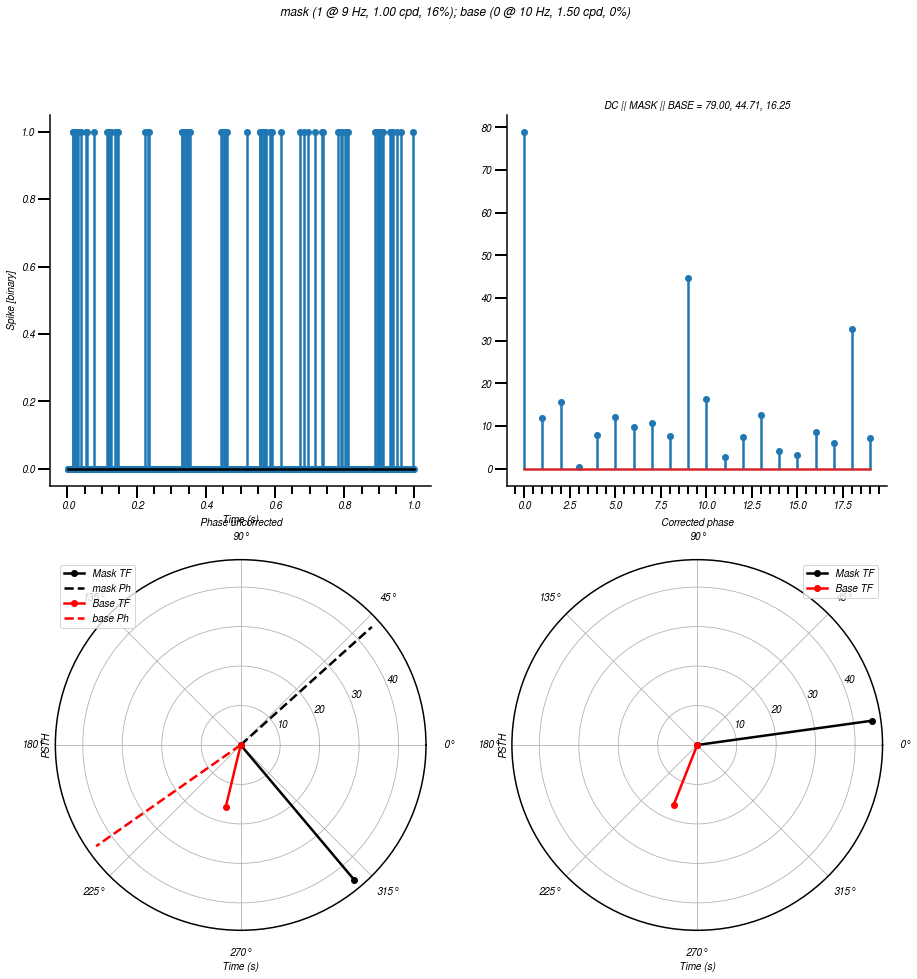

In [465]:
### One trial at a time
# choose a trial
trNum = 512; # 125 is base only; 512 is strong mask only; # 214 is good both
msTenthToS = 1e-4; # the spike times are in 1/10th ms, so multiply by 1e-4 to convert to S
spikeTimes = expInfo['spikeTimes'][trNum]*msTenthToS
# fixed
stimDur = 1

# -- get stimulus info
maskInd, baseInd = hf_sf.get_mask_base_inds();
maskO, baseO = byTrial['maskOn'][trNum], byTrial['baseOn'][trNum]
baseTf, maskTf = byTrial['tf'][baseInd, trNum], byTrial['tf'][maskInd, trNum]
basePh, maskPh = byTrial['ph'][baseInd, trNum], byTrial['ph'][maskInd, trNum]
baseSf, maskSf = byTrial['sf'][baseInd, trNum], byTrial['sf'][maskInd, trNum]
baseCon, maskCon = byTrial['con'][baseInd, trNum], byTrial['con'][maskInd, trNum]

# -- compute PSTH
psth, bins = hf.make_psth([spikeTimes], stimDur=stimDur)
tfAsInts = np.zeros((2,), dtype='int32')
tfAsInts[maskInd] = int(maskTf)
tfAsInts[baseInd] = int(baseTf)
amps, rel_amps, full_fourier = hf.spike_fft([psth], tfs = [tfAsInts], stimDur = stimDur)

# Plot spike times, cycle averaged PSTH
plt.subplots(2, 2, figsize=(15, 15));

plt.suptitle('mask (%d @ %d Hz, %.2f cpd, %d%%); base (%d @ %d Hz, %.2f cpd, %d%%)' % (maskO, maskTf, maskSf, np.round(100*maskCon), 
                                                                                  baseO, baseTf, baseSf, np.round(100*baseCon)));

plt.subplot(2,2,1)
plt.stem(bins[0][1:], psth[0], basefmt='k')
plt.ylabel('Spike [binary]')
plt.xlabel('Time (s)')

# get the (R,phi) for the mask & base components
vec_mask, vec_base = full_fourier[0][0][tfAsInts[maskInd]], full_fourier[0][0][tfAsInts[baseInd]]
r_mask, phi_mask = np.abs(vec_mask), np.angle(vec_mask, deg=True) # will be in deg
r_base, phi_base = np.abs(vec_base), np.angle(vec_base, deg=True) # in deg

plt.subplot(2,2,2);
max_f = 2*np.max(tfAsInts)
plt.stem(amps[0][0][0:max_f])
plt.title('DC || MASK || BASE = %.2f, %.2f, %.2f' % (amps[0][0][0], amps[0][0][tfAsInts[maskInd]], amps[0][0][tfAsInts[baseInd]]));

plt.subplot(2,2,3, projection='polar');
plt.plot([0, np.deg2rad(phi_mask)], [0, r_mask], 'o-k', label='Mask TF')
plt.plot([0, np.deg2rad(maskPh)], [0, r_mask], '--k', label='mask Ph')
plt.plot([0, np.deg2rad(phi_base)], [0, r_base], 'o-r', label='Base TF')
plt.plot([0, np.deg2rad(basePh)], [0, r_mask], '--r', label='base Ph')
plt.ylabel('PSTH')
plt.xlabel('Time (s)')
plt.title('Phase uncorrected')
plt.legend();

plt.subplot(2,2,4, projection='polar');
dir = -1;
maskPh_relStim = np.mod(np.multiply(dir, np.add(phi_mask, maskPh)), 360);
basePh_relStim = np.mod(np.multiply(dir, np.add(phi_base, basePh)), 360);
plt.plot([0, np.deg2rad(maskPh_relStim)], [0, r_mask], 'o-k', label='Mask TF')
plt.plot([0, np.deg2rad(basePh_relStim)], [0, r_base], 'o-r', label='Base TF')
plt.ylabel('PSTH')
plt.xlabel('Time (s)')
plt.title('Corrected phase')
plt.legend();


In [626]:
expInfo.keys()

dict_keys(['trial', 'spikeTimes', 'spikeCounts', 'f1_mask', 'f1_base', 'blank', 'base', 'maskSF', 'baseSF', 'maskCon', 'baseCon'])

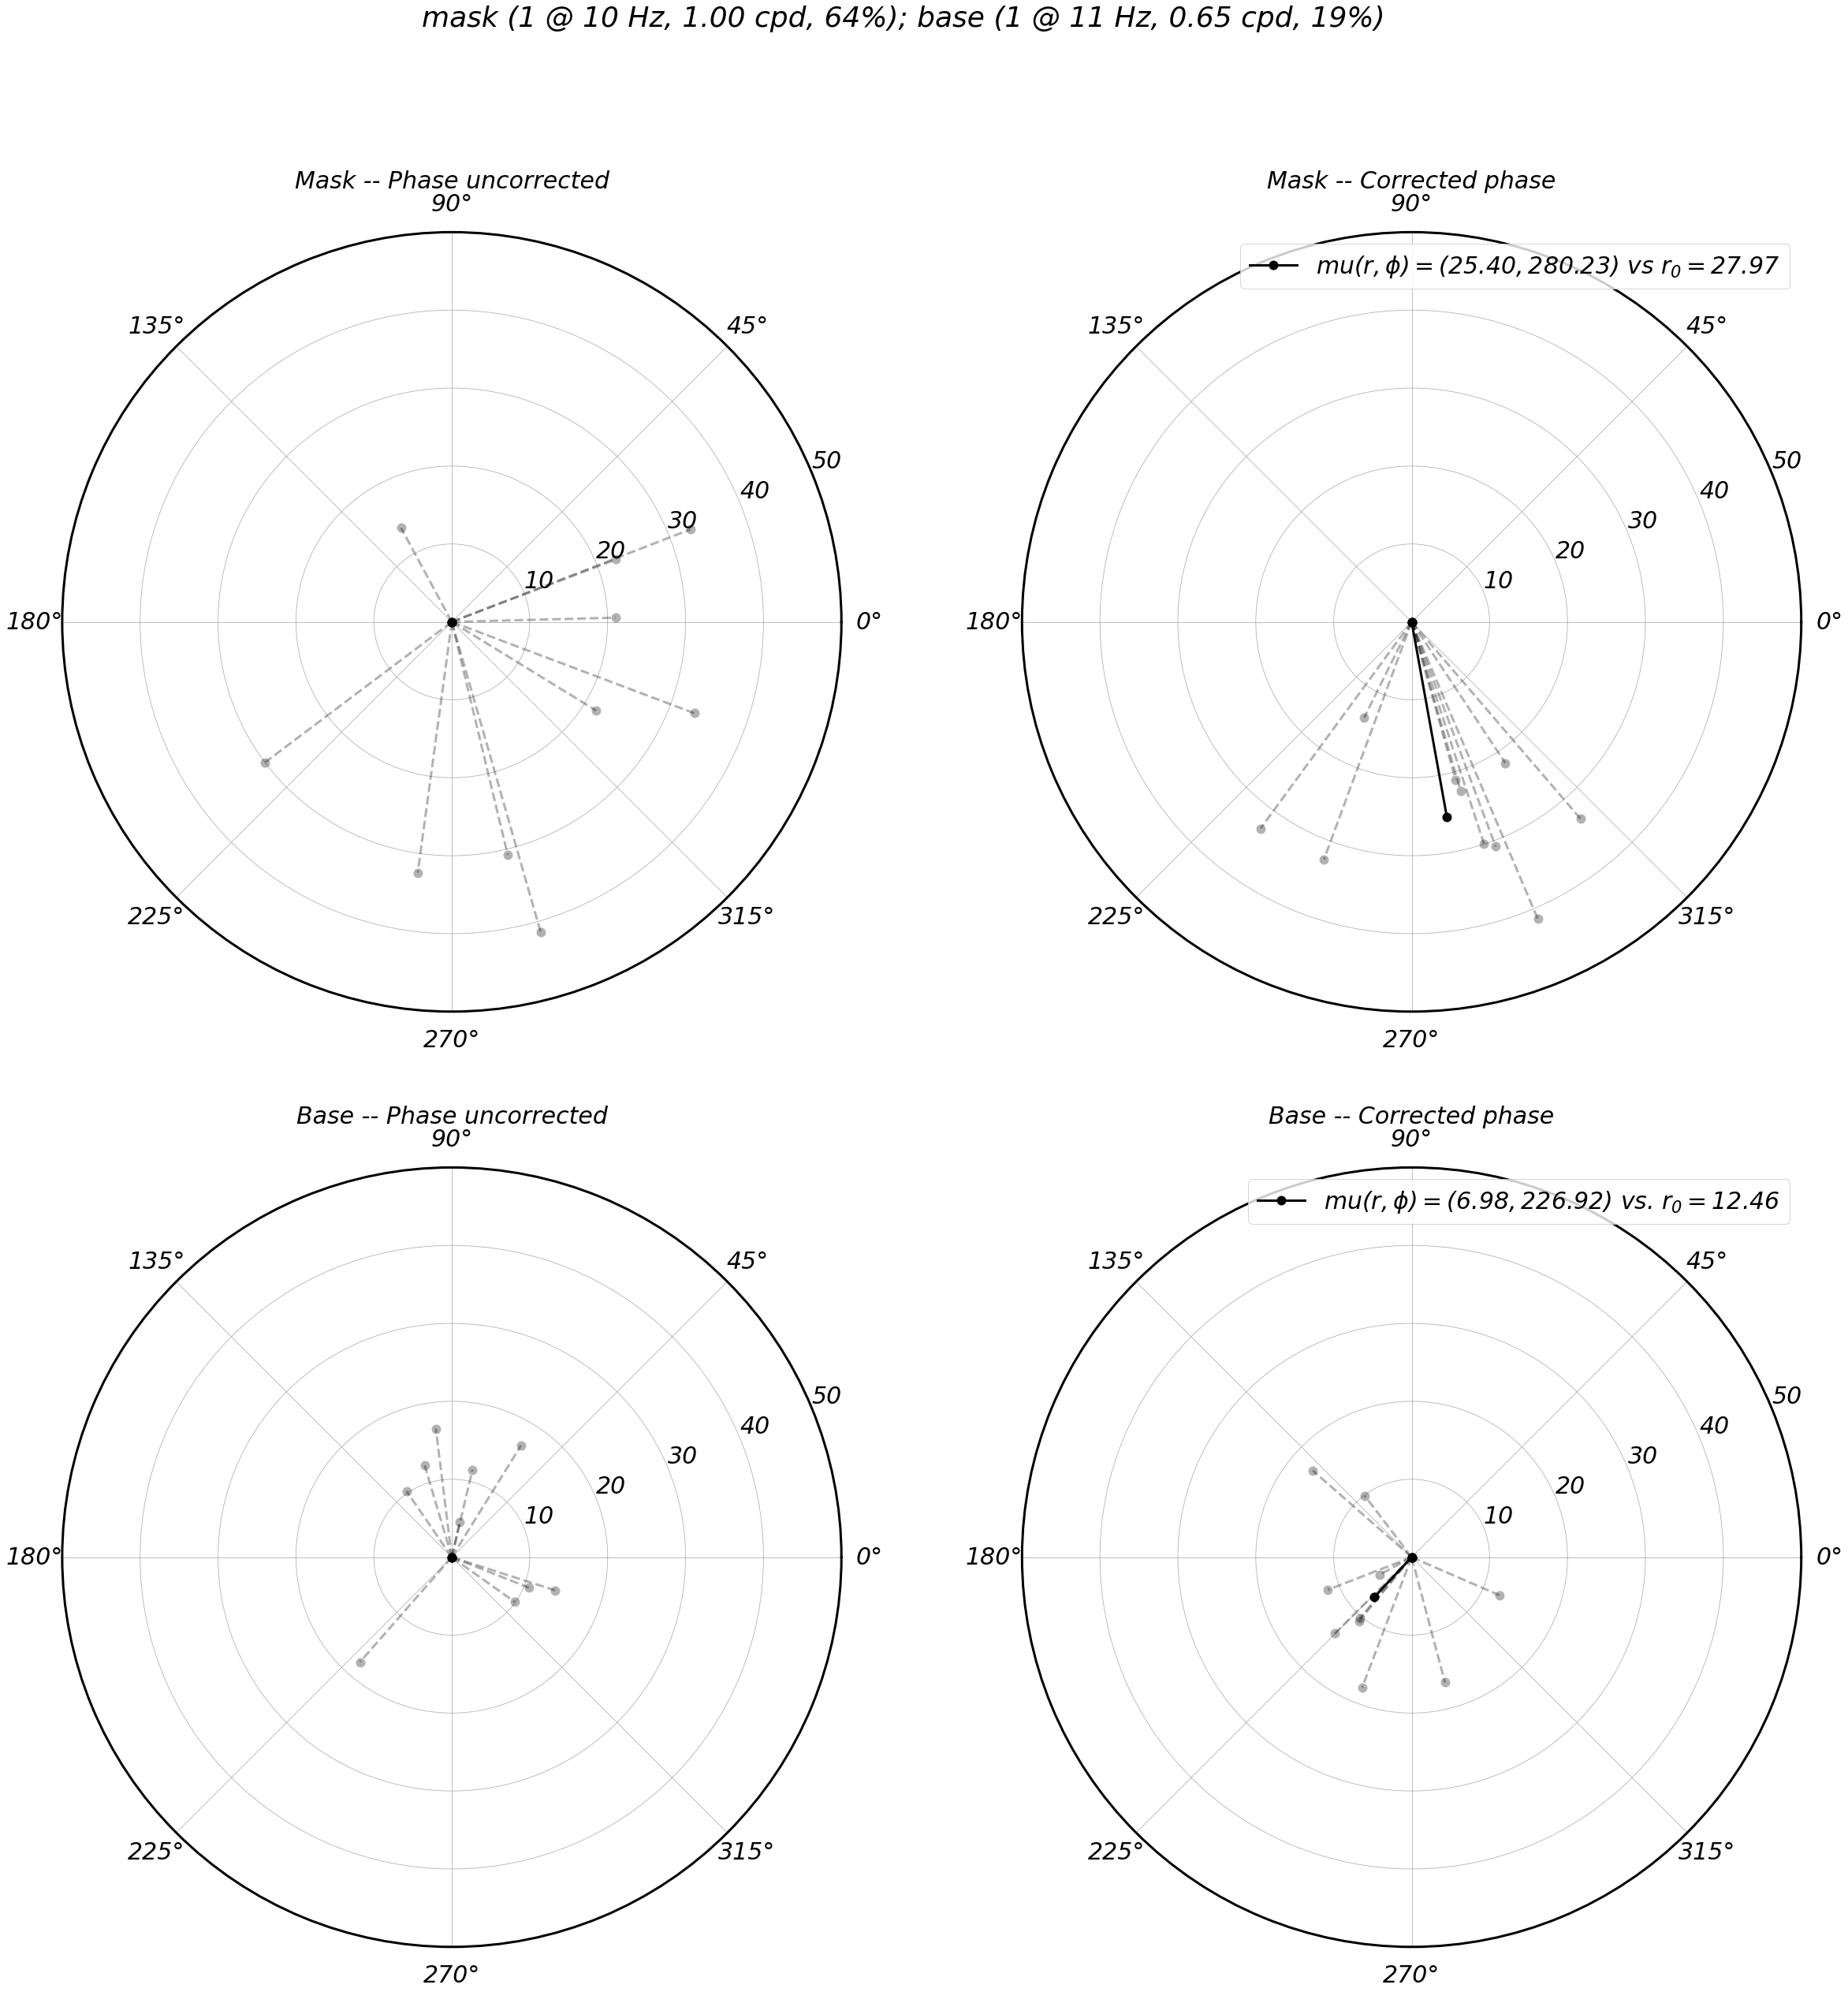

In [646]:
### All trials of the same condition
# fixed
dir = -1;
stimDur = 1
conDig = 2
maskInd, baseInd = hf_sf.get_mask_base_inds();
# Choose which condition to consider
maskOn, baseOn = 1, 1;
whichCon, whichSf = -1, 3;
# Gather all possible stimulus conditions
maskSfs = expInfo['maskSF'];
maskCons = np.round(expInfo['maskCon'], conDig);

# find the right trials
whichComps = np.logical_and(byTrial['maskOn']==maskOn, byTrial['baseOn']==baseOn)
whichSfs = byTrial['sf'][maskInd, :] == maskSfs[whichSf]
whichCons = np.round(byTrial['con'][maskInd, :], conDig) == maskCons[whichCon]
val_trials = np.where(np.logical_and(whichComps, np.logical_and(whichSfs, whichCons)))[0]

# organize the spikes
msTenthToS = 1e-4; # the spike times are in 1/10th ms, so multiply by 1e-4 to convert to S
spikeTimes = [expInfo['spikeTimes'][trNum]*msTenthToS for trNum in val_trials]

# -- get stimulus info
baseTf, maskTf = byTrial['tf'][baseInd, val_trials], byTrial['tf'][maskInd, val_trials]
basePh, maskPh = byTrial['ph'][baseInd, val_trials], byTrial['ph'][maskInd, val_trials]
baseSf, maskSf = byTrial['sf'][baseInd, val_trials], byTrial['sf'][maskInd, val_trials]
baseCon, maskCon = byTrial['con'][baseInd, val_trials], byTrial['con'][maskInd, val_trials]

# -- compute PSTH
psth, bins = hf.make_psth(spikeTimes, stimDur=stimDur)
tfAsInts = np.zeros((len(val_trials),2), dtype='int32')
tfAsInts[:, maskInd] = maskTf;
tfAsInts[:, baseInd] = baseTf;
amps, rel_amps, full_fourier = hf.spike_fft(psth, tfs = tfAsInts, stimDur = stimDur)

resp_phase = np.array([np.angle(full_fourier[x][tfAsInts[x, :]], True) for x in range(len(full_fourier))]); # true --> in degrees                                                          
resp_amp = np.array([amps[tfAsInts[ind, :]] for ind, amps in enumerate(amps)]); # after correction of amps (19.08.06)                                                                   
stimPhs = np.zeros_like(resp_amp);
stimPhs[:, maskInd] = maskPh
stimPhs[:, baseInd] = basePh

phase_rel_stim = np.mod(np.multiply(dir, np.add(resp_phase, stimPhs)), 360);
mean_r, mean_phi, _, _ = hf.polar_vec_mean(np.transpose(resp_amp), np.transpose(phase_rel_stim))
uncorr_r = np.mean(rel_amps, axis=0);

max_r = 10*np.ceil(np.max(resp_amp)/10) # round to the nearest multiple of 10

# Plot spike times, cycle averaged PSTH
f, ax = plt.subplots(2, 2, figsize=(40, 40));

f.suptitle('mask (%d @ %d Hz, %.2f cpd, %d%%); base (%d @ %d Hz, %.2f cpd, %d%%)' % (maskOn, np.unique(maskTf), np.unique(maskSf), np.unique(np.round(100*maskCon)), 
                                                                                  baseOn, np.unique(baseTf), np.unique(baseSf), np.unique(np.round(100*baseCon))));

# MASK (will do base component after)
plt.subplot(2,2,1, projection='polar');
[plt.plot([0, np.deg2rad(phi)], [0, r], 'o--k', alpha=0.3) for phi,r in zip(resp_phase[:, maskInd], resp_amp[:, maskInd])]
plt.title('Mask -- Phase uncorrected')
plt.ylim([0, max_r])

plt.subplot(2,2,2, projection='polar');
[plt.plot([0, np.deg2rad(phi)], [0, r], 'o--k', alpha=0.3) for phi,r in zip(phase_rel_stim[:, maskInd], resp_amp[:, maskInd])]
curr_r, curr_phi = mean_r[maskInd], mean_phi[maskInd]
plt.plot([0, np.deg2rad(curr_phi)], [0, curr_r], 'o-k', label=r'$ mu(r,\phi) = (%.2f, %.2f)$ vs $r_0 = %.2f$' % (curr_r, curr_phi, uncorr_r[maskInd]))
plt.title('Mask -- Corrected phase')
plt.ylim([0, max_r])
plt.legend();

# BASE
plt.subplot(2,2,3, projection='polar');
[plt.plot([0, np.deg2rad(phi)], [0, r], 'o--k', alpha=0.3) for phi,r in zip(resp_phase[:, baseInd], resp_amp[:, baseInd])]
plt.title('Base -- Phase uncorrected')
plt.ylim([0, max_r])

plt.subplot(2,2,4, projection='polar');
[plt.plot([0, np.deg2rad(phi)], [0, r], 'o--k', alpha=0.3) for phi,r in zip(phase_rel_stim[:, baseInd], resp_amp[:, baseInd])]
curr_r, curr_phi = mean_r[baseInd], mean_phi[baseInd]
plt.plot([0, np.deg2rad(curr_phi)], [0, curr_r], 'o-k', label=r'$ mu(r,\phi) = (%.2f, %.2f)$ vs. $r_0 = %.2f$' % (curr_r, curr_phi, uncorr_r[baseInd]))
plt.title('Base -- Corrected phase')
plt.ylim([0, max_r])
plt.legend();

saveName = "/cell_%03d_phaseCorr_sf%03d_con%03d_b%d_m%d.pdf" % (cellNum, np.int(100*np.unique(maskSf)), np.int(100*np.unique(maskCon)), maskOn, baseOn)

full_save = os.path.dirname(str(save_loc + 'phase_corr/%s/cell_%03d/' % (expName, cellNum)));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
# plt.close(f)
pdfSv.close()



## Core experiment (Bauman+Bonds) -- plotting

In [31]:
expDir = 'V1_BB/';
path = '%sstructures/' % expDir;
dataList = hf.np_smart_load(path + 'dataList.npy')

save_loc = '%sfigures/' % expDir;

baselineSub = 0;
fix_ylim = 0;

if fix_ylim == 1:
    ylim_flag = '_fixed';
else:
    ylim_flag = ''

### Plot single grating RVCs and SF tuning curves

In [ ]:
for cellNum in np.arange(1, len(dataList['unitName'])+1):
    expName = 'sfBB_core';

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));
    expInfo = cell[expName]
    byTrial = expInfo['trial'];

    respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=0);
    maskSf, maskCon = expInfo['maskSF'], expInfo['maskCon'];
    f1f0_rat = hf_sf.compute_f1f0(expInfo)[0];
    ### Now, plot
    nrow, ncol = 3, 2;
    f, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*15, nrow*15))

    f.suptitle('V1 #%d [%s, f1f0: %.2f]' % (cellNum, unitNm, f1f0_rat));
    # assumes no baseline subtraction...
    maxResp = np.maximum(np.max(respMatrixDC[:,:,0]), np.max(respMatrixF1[:,:,0]))
    yLims = [0, 1.1*maxResp];
    
    for measure in [0,1]:
        if measure == 0:
            baseline = expInfo['blank']['mean'];
            data = respMatrixDC
            if baselineSub:
                data -= baseline;
            lbl = 'DC'
        elif measure == 1:
            data = respMatrixF1
            lbl = 'F1'

        # joint tuning
        ax[0, measure].contourf(maskSf, maskCon, data[:,:,0])
        ax[0, measure].set_xlabel('Spatial frequency (c/deg)');
        if measure == 0:
            ax[0, measure].set_ylabel('Contrast (%)');
        ax[0, measure].set_xscale('log');
        ax[0, measure].set_yscale('log');
        ax[0, measure].set_title('Joint tuning (%s)' % lbl)
    #     ax[measure,0].set_colorbar();

        # SF tuning with contrast
        lines = [];
        nCons = len(maskCon);
        for mcI, mC in enumerate(maskCon):
            col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

            curr_line = ax[1, measure].errorbar(maskSf, data[mcI,:,0], data[mcI,:,1], marker='o', 
                                                color=col, label=str(np.round(mC, 2)) + '%')
            ax[1, measure].set_xscale('log');
            ax[1, measure].set_xlabel('SF (c/deg)')
            ax[1, measure].set_ylim(yLims);
            if measure == 0:
                ax[1, measure].set_ylabel('Response (spks/s) [%s]' % lbl)
            lines.append(curr_line);

        if measure == 0:
            ax[1, measure].axhline(baseline, color='r', linestyle='--', label='blank');
        ax[1, measure].legend(fontsize='x-small');

        # RVC across SF
        lines = [];
        nSfs = len(maskSf);
        for msI, mS in enumerate(maskSf):
            col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

            curr_line = ax[2, measure].errorbar(maskCon, data[:,msI,0], data[:,msI,1], marker='o', 
                                                color=col, label=str(np.round(mS, 2)) + ' cpd')
            ax[2, measure].set_xscale('log');
            ax[2, measure].set_xlabel('Contrast (%)')
            ax[2, measure].set_ylim(yLims);
            if measure == 0:
                ax[2, measure].set_ylabel('Response (spks/s) [%s]' % lbl)
            lines.append(curr_line);

        if measure == 0:
            ax[2, measure].axhline(baseline, color='r', linestyle='--', label='blank');
        ax[2, measure].legend(fontsize='x-small');

    sns.despine(offset=10)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    saveName = "/cell_%03d_.pdf" % (cellNum)
    full_save = os.path.dirname(str(save_loc + 'summary%s/core/' % ylim_flag));
    if not os.path.exists(full_save):
        os.makedirs(full_save);
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f)
    plt.close(f)
    pdfSv.close()


### Interlude: Tuning distrubitions, maximum responses

In [ ]:
### This will take ~3 minutes
nCells = len(dataList['unitName']);
prefSf_data = np.zeros((nCells, 2));
prefSf_mod = np.zeros((nCells, 2));
maxResp = np.zeros((nCells, 2));

for cellNum in np.arange(1, nCells+1):
    expName = 'sfBB_core';

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));
    expInfo = cell[expName]
    byTrial = expInfo['trial'];

    respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=0);
    maskSf, maskCon = expInfo['maskSF'], expInfo['maskCon'];
    
    sfHighCon = [respMatrixDC[-1,:,0], respMatrixF1[-1,:,0]]
    prefSf_data[cellNum-1, :] = [maskSf[np.argmax(x)] for x in sfHighCon]
    prefSf_mod[cellNum-1, :] = [hf.tfTune(maskSf, x, tfResps_std=None, baselineSub=False, nOpts = 30)[0] for x in sfHighCon]
    maxResp[cellNum-1, :] = [np.max(x) for x in sfHighCon];

In [ ]:
### Plot prefSf distr, then maxResp distr

## now setup plot
nrow, ncol = 2, 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*15, nrow*12), sharey=True)

## SF
bins = np.linspace(-2.5, 3.5, 9); # in log space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

psfs = [prefSf_mod[:,0], prefSf_mod[:,1]];
fitStr = ['DC', 'F1']

psfs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in psfs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nSF = [len(x) for x in psfs_clipped]
medianSF = [np.nanmedian(x) for x in psfs];
mnSF = [np.nanmean(x) for x in psfs];
gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];
ylim = [0, 0.35]

for i in range(2):

    plt.subplot(nrow,ncol,1+i)
    vals, _ = np.histogram(psfs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.ylim(ylim);
    plt.xlabel('spatial frequency (c/deg)');
    plt.title('Distr. of freq pref [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nSF[i], medianSF[i], mnSF[i], gmnSF[i]));

## Max resp
bins = np.linspace(0, 120, 9); # in linear space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;

clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

maxResps = [maxResp[:,0], maxResp[:,1]];
maxResps_clipped = [np.clip(hf.nan_rm(x), clipLow, clipHigh) for x in maxResps];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nMR = [len(x) for x in maxResps_clipped]
medianMR = [np.nanmedian(x) for x in maxResps];
mnMR = [np.nanmean(x) for x in maxResps];
ylim = [0, 0.5]

for i in range(2):

    plt.subplot(nrow,ncol, ncol+1+i)
    vals, _ = np.histogram(maxResps_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)

    plt.xlabel('Response (spks/s)');
    plt.title('Distribution of maximum response [%s] (V1, n=%d, median=%.2f, mn=%.2f)' % (fitStr[i], nMR[i], medianMR[i], mnMR[i]));
    plt.ylim(ylim);
    
# now save
saveName = "/sf_maxResp_sfBB.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc + 'pop_distr/'));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()

### Plot the influence of the mask on base response

In [231]:
import model_responses_pytorch as mrpt

In [232]:
autoreload.reload(mrpt)
autoreload.reload(hf)
autoreload.reload(hf_sf)

<module 'helper_fcns_sfBB' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns_sfBB.py'>

In [235]:
# modFits = hf.np_smart_load('V1_BB/structures/fitList_pyt_200507_LGN_flat_poiss.npy')
modFits = hf.np_smart_load('V1_BB/structures/fitList_pyt_200507_wght_sqrt.npy')
cellNum = 1;
currFits = modFits[cellNum-1];

datalist = hf.np_smart_load('V1_BB/structures/dataList.npy');
curr_cell = hf.np_smart_load('V1_BB/structures/%s_sfBB.npy' % datalist['unitName'][cellNum-1])

In [236]:
coreExp = curr_cell['sfBB_core'];
newMethod = 1;
excType = 2;
lossType = 2;
normType = 2;
lgnFrontEnd = 1;

# first DC
respMeasure = 0; # 0 for DC; 1 for F1
prms = currFits['dc']['params'];
curr_mod = mrpt.sfNormMod(modParams=prms, excType=excType, expInd=-1, normType=normType, 
                          lgnFrontEnd=lgnFrontEnd, lossType=lossType, newMethod=newMethod)
trInf_dc, resp_dc = mrpt.process_data(coreExp, expInd=-1, respMeasure=respMeasure)
mod_resps_dc = curr_mod.forward(trInf_dc, respMeasure=respMeasure).detach().numpy();
    
# then F1
respMeasure = 1; # 0 for DC; 1 for F1
prms = currFits['f1']['params'];
curr_mod = mrpt.sfNormMod(modParams=prms, excType=excType, expInd=-1, normType=normType, 
                          lgnFrontEnd=lgnFrontEnd, lossType=lossType, newMethod=newMethod)
trInf_f1, resp_f1 = mrpt.process_data(coreExp, expInd=-1, respMeasure=respMeasure)
mod_resps_f1 = curr_mod.forward(trInf_f1, respMeasure=respMeasure).detach().numpy();

coreMod = coreExp.copy()
coreMod['spikeCounts'] = mod_resps_dc;
coreMod['f1_base'] = mod_resps_f1[:,0];
coreMod['f1_mask'] = mod_resps_f1[:,1];

KeyError: 'params'

Text(0.5, 1.0, 'F1::mask')

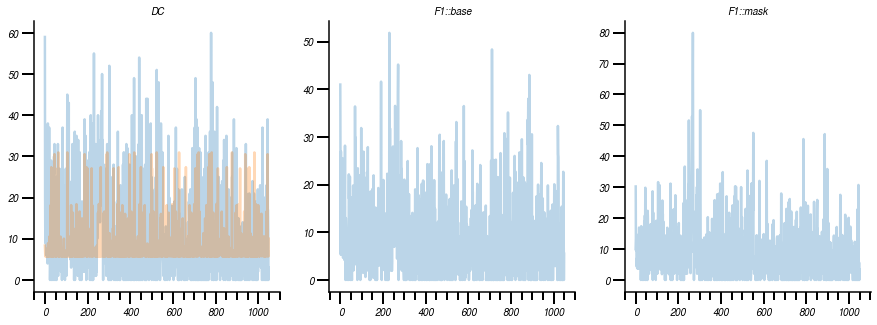

In [211]:
ncol=3; nrow=1
f, ax = plt.subplots(nrow, ncol, figsize=(5*ncol, 5*nrow))

valTrials = trInf['num']

ax[0].plot(coreExp['spikeCounts'][valTrials], alpha=0.3);
ax[0].plot(coreMod['spikeCounts'], alpha=0.3)
ax[0].set_title('DC')

ax[1].plot(coreExp['f1_base'][valTrials], alpha=0.3);
ax[1].plot(coreMod['f1_base'], alpha=0.3)
ax[1].set_title('F1::base')

ax[2].plot(coreExp['f1_mask'][valTrials], alpha=0.3);
ax[2].plot(coreMod['f1_mask'], alpha=0.3)
ax[2].set_title('F1::mask')


In [212]:
import torch

In [213]:
[x for x in curr_mod.named_parameters()]

[('mWeight',
  Parameter containing:
  tensor(1.3268, requires_grad=True)),
 ('prefSf',
  Parameter containing:
  tensor(1.3571, requires_grad=True)),
 ('sigLow',
  Parameter containing:
  tensor(1.3235, requires_grad=True)),
 ('sigHigh',
  Parameter containing:
  tensor(2.6384, requires_grad=True)),
 ('sigma',
  Parameter containing:
  tensor(-1.9601, requires_grad=True)),
 ('respExp',
  Parameter containing:
  tensor(3.0682, requires_grad=True)),
 ('scale',
  Parameter containing:
  tensor(0.7748, requires_grad=True)),
 ('noiseEarly',
  Parameter containing:
  tensor(-0.0289, requires_grad=True)),
 ('noiseLate',
  Parameter containing:
  tensor(0.0434, requires_grad=True)),
 ('gs_mean',
  Parameter containing:
  tensor(-0.0864, requires_grad=True)),
 ('gs_std',
  Parameter containing:
  tensor(2.6384, requires_grad=True))]

In [229]:
sfs = mrpt._cast_as_tensor(np.geomspace(0.3, 10, 100));
log_sfs = torch.log(sfs);
gs_mean = mrpt._cast_as_tensor(curr_mod.gs_mean);
gs_std = mrpt._cast_as_tensor(curr_mod.gs_std);
weight_distr = torch.distributions.normal.Normal(gs_mean, gs_std)
new_weights = torch.exp(weight_distr.log_prob(log_sfs));

lgnStage = torch.ones_like(sfs);
new_weights = torch.mul(lgnStage, new_weights);


/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/model_responses_pytorch.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


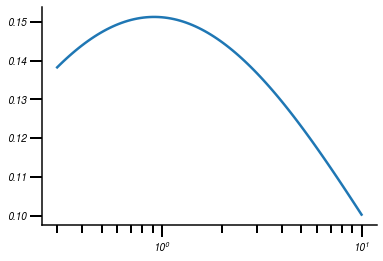

In [230]:
plt.semilogx(sfs, new_weights)

In [180]:
coreMod.keys()

dict_keys(['trial', 'spikeTimes', 'spikeCounts', 'f1_mask', 'f1_base', 'blank', 'base', 'maskSF', 'baseSF', 'maskCon', 'baseCon'])

#### Updated method: Show mask+base response in addition to mask alone (rather than jumping straight to R(mask+base) - R(base)

In [52]:
for cellNum in np.arange(1, len(dataList['unitName'])+1):
    expName = 'sfBB_core';

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));
    expInfo = cell[expName]
    byTrial = expInfo['trial'];
    f1f0_rat = hf_sf.compute_f1f0(expInfo)[0];

    ### Get the responses - base only, mask+base [base F1], mask only (mask F1)
    baseDistrs, _, baseConds = hf_sf.get_baseOnly_resp(expInfo);
    # - unpack DC, F1 distribution of responses per trial
    baseDC, baseF1 = baseDistrs;
    baseDC_mn, baseF1_mn = np.mean(baseDC), np.mean(baseF1);
    # - unpack the SF x CON of the base (guaranteed to have only one set for sfBB_core)
    baseSf_curr, baseCon_curr = baseConds[0];
    # now get the mask+base response (f1 at base TF)
    respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=0); # i.e. get the base response for F1
    # and get the mask only response (f1 at mask TF)
    respMatrixDC_onlyMask, respMatrixF1_onlyMask = hf_sf.get_mask_resp(expInfo, withBase=0, maskF1=1); # i.e. get the maskONLY response
    # and get the mask+base response (but f1 at mask TF)
    _, respMatrixF1_maskTf = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=1); # i.e. get the maskONLY response

    ## Reference tuning...
    refDC, refF1 = hf_sf.get_mask_resp(expInfo, withBase=0); # i.e. mask only, at mask TF
    maskSf, maskCon = expInfo['maskSF'], expInfo['maskCon'];
    # - get DC tuning curves
    refDC_sf = refDC[-1, :, :]; # highest contrast
    prefSf_ind = np.argmax(refDC_sf[:, 0]);
    prefSf_DC = maskSf[prefSf_ind];
    refDC_rvc = refDC[:, prefSf_ind, :];
    # - get F1 tuning curves
    refF1_sf = refF1[-1, :, :];
    prefSf_ind = np.argmax(refF1_sf[:, 0]);
    prefSf_F1 = maskSf[prefSf_ind];
    refF1_rvc = refF1[:, prefSf_ind, :];
    
    ### Now, plot
    nrow, ncol = 5, 4;
    f, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*15, nrow*15))

    f.suptitle('V1 #%d [%s, f1f0: %.2f] base: %.2f cpd, %.2f%%' % (cellNum, unitNm, f1f0_rat, baseSf_curr, baseCon_curr),
              fontsize='x-large');
    
    maxResp = np.maximum(np.max(respMatrixDC), np.max(respMatrixF1));
    maxResp_onlyMask = np.maximum(np.max(respMatrixDC_onlyMask), np.max(respMatrixF1_onlyMask));
    maxResp_total = np.maximum(maxResp, maxResp_onlyMask);
    overall_ylim = [0, 1.2*maxResp_total];
    # also get the bounds for the AbLe plot - only DC
    AbLe_mn = np.nanmin(respMatrixDC[:,:,0]-baseDC_mn-respMatrixDC_onlyMask[:,:,0])
    AbLe_mx = np.nanmax(respMatrixDC[:,:,0]-baseDC_mn-respMatrixDC_onlyMask[:,:,0])
    AbLe_bounds = [np.sign(AbLe_mn)*1.2*np.abs(AbLe_mn), np.maximum(5, 1.2*AbLe_mx)]; # ensure we go at least above 0 with the max
    
    ######
    for measure in [0,1]:
        if measure == 0:
            baseline = expInfo['blank']['mean'];
            data = respMatrixDC;
            data_baseTF = None;
            maskOnly = respMatrixDC_onlyMask;
            baseOnly = baseDC
            refAll = refDC[:,:,0];
            refSf = refDC_sf;
            refRVC = refDC_rvc;
            refSf_pref = prefSf_DC;
            if baselineSub:
                data -= baseline
                baseOnly -= baseline;
            xlim_base = overall_ylim;
            ylim_diffsAbLe = AbLe_bounds;
            lbl = 'DC'
        elif measure == 1:
            data = respMatrixF1_maskTf;
            data_baseTf = respMatrixF1;
            maskOnly = respMatrixF1_onlyMask;
            baseOnly = baseF1;
            refAll = refF1[:,:,0];
            refSf = refF1_sf;
            refRVC = refF1_rvc;
            refSf_pref = prefSf_F1;
            xlim_base = overall_ylim
            lbl = 'F1'

        # Now, subtract the baseOnly response from the base+mask response (base frequency for F1)
        # -- but store it separately 
        data_sub = np.copy(data);
        data_sub[:,:,0] = data[:,:,0]-np.mean(baseOnly);

        ### first, just the distribution of base responses
        ax[0, measure] = plt.subplot(nrow, 2, 1+measure); # pretend there are only 2 columns

        sns.distplot(baseOnly, ax=ax[0, measure], kde=False);
        base_mn, base_sem = np.mean(baseOnly), np.std(baseOnly)/len(baseOnly);

        ax[0, measure].set_xlim(xlim_base)
        ax[0, measure].set_title('[%s] mn|sem = %.2f|%.2f' % (lbl, base_mn, base_sem))
        if measure == 0:
            ax[0, measure].axvline(baseline, linestyle='--', color='r')

        # SF tuning with contrast
        resps = [maskOnly, data, data_baseTf]; #need to plot data_baseTf for f1
        labels = ['mask', 'mask+base', 'mask+base']
        measure_lbl = np.vstack((['', '', ''], ['', ' (mask TF)', ' (base TF)'])); # specify which TF, if F1 response
        labels_ref = ['blank', 'base']
        floors = [baseline, base_mn]; # i.e. the blank response, then the response to the base alone
        
        for ii, rsps in enumerate(resps): # first mask only, then mask+base (data)
            nCons = len(maskCon);
            # we don't plot the F1 at base TF for DC response...
            if measure == 0 and ii == (len(resps)-1):
                continue;

            for mcI, mC in enumerate(maskCon):

                col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

                curr_line = ax[1+ii, 2*measure].errorbar(maskSf, rsps[mcI,:,0], rsps[mcI,:,1], marker='o', 
                                                    color=col, label=str(np.round(mC, 2)) + '%')
            ax[1+ii, 2*measure].set_xscale('log');
            ax[1+ii, 2*measure].set_xlabel('SF (c/deg)')
            ax[1+ii, 2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
            ax[1+ii, 2*measure].set_title(labels[ii] + measure_lbl[measure, ii]);
            ax[1+ii, 2*measure].set_ylim(overall_ylim);
            if measure == 0: # only do the blank response reference for DC
                ax[1+ii, 2*measure].axhline(floors[0], linestyle='--', color='r', label=labels_ref[0])
            # i.e. always put the baseOnly reference line...
            ax[1+ii, 2*measure].axhline(floors[1], linestyle='--', color='b', label=labels_ref[1])
            ax[1+ii, 2*measure].legend(fontsize='small');

        # RVC across SF
        for ii, rsps in enumerate(resps): # first mask only, then mask+base (data)
            nSfs = len(maskSf);

            # we don't plot the F1 at base TF for DC response...
            if measure == 0 and ii == (len(resps)-1):
                continue;

            for msI, mS in enumerate(maskSf):
                
                col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

                curr_line = ax[1+ii, 1+2*measure].errorbar(maskCon, rsps[:,msI,0], rsps[:,msI,1], marker='o', 
                                                    color=col, label=str(np.round(mS, 2)) + ' cpd')
            ax[1+ii, 1+2*measure].set_xscale('log');
            ax[1+ii, 1+2*measure].set_xlabel('Contrast (%)')
            ax[1+ii, 1+2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
            ax[1+ii, 1+2*measure].set_title(labels[ii] + measure_lbl[measure, ii])
            ax[1+ii, 1+2*measure].set_ylim(overall_ylim);
            if measure == 0: # only do the blank response for DC
                ax[1+ii, 1+2*measure].axhline(floors[0], linestyle='--', color='r', label=labels_ref[0])
            # i.e. always put the baseOnly reference line...
            ax[1+ii, 1+2*measure].axhline(floors[1], linestyle='--', color='b', label=labels_ref[1])
            ax[1+ii, 1+2*measure].legend(fontsize='small');

        ### joint tuning (mask only)
        ax[4, measure] = plt.subplot(nrow, 2, 2*nrow-1+measure); # pretend there are only 2 columns

        ax[4, measure].contourf(maskSf, maskCon, refAll)
        ax[4, measure].set_xlabel('Spatial frequency (c/deg)');
        ax[4, measure].set_ylabel('Contrast (%)');
        ax[4, measure].set_xscale('log');
        ax[4, measure].set_yscale('log');
        ax[4, measure].set_title('Joint REF tuning (%s)' % lbl)

        ### SF tuning with contrast [rows 1-4, column 1 (& 3)]
#         lines = []; linesNorm = []; linesAbLe = [];
        nCons = len(maskCon);
        for mcI, mC in enumerate(maskCon):
            col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

            if measure == 0:
                curr_line = ax[3, 2*measure].errorbar(maskSf, data_sub[mcI,:,0]-maskOnly[mcI,:,0], data_sub[mcI,:,1],
                                                      marker='o', color=col, label=str(np.round(mC, 2)) + '%')
#                 linesAbLe.append(curr_line);
                ax[3, 2*measure].set_ylim(ylim_diffsAbLe)
#             else:
#                 ax[3, 2*measure].axis('off'); # cannot do Abramov-Levine with F1!
                 
        ylim_diffs = [ylim_diffsAbLe];
        diff_endings = [' - R(m))'];
        for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
            ax[3+j, 2*measure].set_xscale('log');
            ax[3+j, 2*measure].set_xlabel('SF (c/deg)')
            ax[3+j, 2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt,lbl))
            if measure==1: # Abramov/Levine sub. -- only DC has this analysis
                pass;
            else:
                ax[3+j, 2*measure].axhline(0, color='k', linestyle='--')
            ax[3+j, 2*measure].legend(fontsize='small');

        ### RVC across SF [rows 1-4, column 2 (& 4)]
        lines = []; linesNorm = []; linesAbLe = [];
        nSfs = len(maskSf);
        for msI, mS in enumerate(maskSf):
            col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

            if measure == 0:
                curr_line = ax[3, 1+2*measure].errorbar(maskCon, data_sub[:,msI,0] - maskOnly[:,msI,0], data_sub[:,msI,1],
                                                        marker='o', color=col, label=str(np.round(mS, 2)) + ' cpd')
                linesAbLe.append(curr_line);
                ax[3, 1+2*measure].set_ylim(ylim_diffsAbLe)

        for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
            ax[3+j, 1+2*measure].set_xscale('log');
            ax[3+j, 1+2*measure].set_xlabel('Contrast (%%)')
#             ax[3+j, 1+2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt, lbl))
            if measure==1: # Abramov/Levine sub. -- only DC has this analysis
                pass;
            else:
                ax[3+j, 1+2*measure].axhline(0, color='k', linestyle='--')
            ax[3+j, 1+2*measure].legend(fontsize='small');

    sns.despine(offset=10)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])

    saveName = "/cell_%03d_both.pdf" % (cellNum)
    full_save = os.path.dirname(str(save_loc + 'summary/core/both/'));
    if not os.path.exists(full_save):
        os.makedirs(full_save);
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f)
    plt.close(f)
    pdfSv.close()


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#### Original method (separate plot for influence of mask)

In [ ]:
expDir = 'V1_BB/';
path = '%sstructures/' % expDir;
dataList = hf.np_smart_load(path + 'dataList.npy')

save_loc = '%sfigures/' % expDir;

baselineSub = 0;
fix_ylim = 0;

if fix_ylim == 1:
    ylim_flag = '';
else:
    ylim_flag = '_free'

In [ ]:
for cellNum in np.arange(1, len(dataList['unitName'])+1):
    expName = 'sfBB_core';

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));
    expInfo = cell[expName]
    byTrial = expInfo['trial'];

    f1f0_rat = hf_sf.compute_f1f0(expInfo)[0];
    ### Get the responses - base only, mask+base [base F1], mask only (mask F1)
    baseDistrs, _, baseConds = hf_sf.get_baseOnly_resp(expInfo);
    # - unpack DC, F1 distribution of responses per trial
    baseDC, baseF1 = baseDistrs;
    # - unpack the SF x CON of the base (guaranteed to have only one set for sfBB_core)
    baseSf_curr, baseCon_curr = baseConds[0];
    # now get the mask+base response (f1 at base TF)
    respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=0); # i.e. get the base response for F1
    # and get the mask only response (f1 at mask TF);
    respMatrixDC_onlyMask, respMatrixF1_onlyMask = hf_sf.get_mask_resp(expInfo, withBase=0, maskF1=1); # i.e. get the maskONLY response

    ## Reference tuning...
    refDC, refF1 = hf_sf.get_mask_resp(expInfo, withBase=0); # i.e. mask only, at mask TF
    maskSf, maskCon = expInfo['maskSF'], expInfo['maskCon'];
    # - get DC tuning curves
    refDC_sf = refDC[-1, :, :]; # highest contrast
    prefSf_ind = np.argmax(refDC_sf[:, 0]);
    prefSf_DC = maskSf[prefSf_ind];
    refDC_rvc = refDC[:, prefSf_ind, :];
    # - get F1 tuning curves
    refF1_sf = refF1[-1, :, :];
    prefSf_ind = np.argmax(refF1_sf[:, 0]);
    prefSf_F1 = maskSf[prefSf_ind];
    refF1_rvc = refF1[:, prefSf_ind, :];
    
    ### Now, plot
    nrow, ncol = 5+fix_ylim, 4;
    f, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*15, nrow*15))

    f.suptitle('V1 #%d [%s, f1f0: %.2f] base: %.2f cpd, %.2f%%' % (cellNum, unitNm, f1f0_rat, baseSf_curr, baseCon_curr));
    
    maxResp = np.maximum(np.max(respMatrixDC), np.max(respMatrixF1));
    maxResp_onlyMask = np.maximum(np.max(respMatrixDC_onlyMask), np.max(respMatrixF1_onlyMask));
    maxResp_total = np.maximum(maxResp, maxResp_onlyMask);
    overall_ylim = [0, 1.2*maxResp_total];
    # get the bounds for the difference plot (R(m+b) - R(b))
    dc_min = np.nanmin(respMatrixDC[:,:,0]-np.mean(baseDC))
    dc_max = np.nanmax(respMatrixDC[:,:,0]-np.mean(baseDC))
    f1_min = np.nanmin(respMatrixDC[:,:,0]-np.mean(baseF1))
    f1_max = np.nanmax(respMatrixDC[:,:,0]-np.mean(baseF1))
    diff_min = np.minimum(dc_min, f1_min);
    diff_max = np.maximum(dc_max, f1_max);
    diff_bounds = [np.sign(diff_min)*1.2*np.abs(diff_min), np.maximum(5, 1.2*diff_max)]; # ensure we go at least above 0 with the max
    # also get the bounds for the AbLe plot - only DC
    AbLe_mn = np.nanmin(respMatrixDC[:,:,0]-np.mean(baseDC)-respMatrixDC_onlyMask[:,:,0])
    AbLe_mx = np.nanmax(respMatrixDC[:,:,0]-np.mean(baseDC)-respMatrixDC_onlyMask[:,:,0])
    AbLe_bounds = [np.sign(AbLe_mn)*1.2*np.abs(AbLe_mn), np.maximum(5, 1.2*AbLe_mx)]; # ensure we go at least above 0 with the max

    ######
    for measure in [0,1]:
        if measure == 0:
            baseline = expInfo['blank']['mean'];
            data = respMatrixDC;
            data_baseTf = None;
            maskOnly = respMatrixDC_onlyMask;
            baseOnly = baseDC
            refAll = refDC[:,:,0];
            refSf = refDC_sf;
            refRVC = refDC_rvc;
            refSf_pref = prefSf_DC;
            if baselineSub:
                data -= baseline
                baseOnly -= baseline;
            xlim_base = [-5, 120]
            if fix_ylim == 1:
                ylim_diffs = [-50, 60]
                ylim_diffNorm = [-1.5, 1.5];
                ylim_diffsAbLe = [-100, 20]
            else:
                ylim_diffs = diff_bounds;
                ylim_diffsAbLe = AbLe_bounds;
            lbl = 'DC'
        elif measure == 1:
            data = respMatrixF1_maskTf;
            data_baseTf = respMatrixF1;
            maskOnly = respMatrixF1_onlyMask;
            baseOnly = baseF1;
            refAll = refF1[:,:,0];
            refSf = refF1_sf;
            refRVC = refF1_rvc;
            refSf_pref = prefSf_F1;
            xlim_base = [-5, 120]
            if fix_ylim == 1:
                ylim_diffs = [-40, 40]
                ylim_diffNorm = [-1.5, 1.5];
            else:
                ylim_diffs = diff_bounds;
            lbl = 'F1'

        # Now, subtract the baseOnly response from the base+mask response (base frequency for F1)
        data[:,:,0] = data[:,:,0]-np.mean(baseOnly);

        ### first, just the distribution of base responses
        ax[0, measure] = plt.subplot(nrow, 2, 1+measure); # pretend there are only 2 columns

        sns.distplot(baseOnly, ax=ax[0, measure], kde=False);
        base_mn, base_sem = np.mean(baseOnly), np.std(baseOnly)/len(baseOnly);

        ax[0, measure].set_xlim(xlim_base)
        ax[0, measure].set_title('[%s] mn|sem = %.2f|%.2f' % (lbl, base_mn, base_sem))
        if measure == 0:
            ax[0, measure].axvline(baseline, linestyle='--', color='r')

        # - now, the normalized change in response
        print('base mean %.2f' % base_mn)
        dataNorm = np.divide(data[:,:,0], base_mn);

        ### basic tunings (SF, RVC)
        # SF tuning with contrast
        lines = [];
        nCons = len(maskCon);
        for mcI, mC in enumerate(maskCon):
            col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];
            
            curr_line = ax[1, 2*measure].errorbar(maskSf, maskOnly[mcI,:,0], maskOnly[mcI,:,1], marker='o', 
                                                color=col, label=str(np.round(mC, 2)) + '%')
            ax[1, 2*measure].set_xscale('log');
            ax[1, 2*measure].set_xlabel('SF (c/deg)')
            ax[1, 2*measure].set_ylim(overall_ylim);
            if measure == 0:
                ax[1, 2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
            lines.append(curr_line);

        if measure == 0:
            ax[1, 2*measure].axhline(baseline, color='r', linestyle='--', label='blank');
        ax[1, 2*measure].legend(fontsize='x-small');
        ax[1, 2*measure].set_title('mask only')

        # RVC across SF
        lines = [];
        nSfs = len(maskSf);
        for msI, mS in enumerate(maskSf):
            col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];
            
            curr_line = ax[1, 1+2*measure].errorbar(maskCon, maskOnly[:,msI,0], maskOnly[:,msI,1], marker='o', 
                                                color=col, label=str(np.round(mS, 2)) + ' cpd')
            ax[1, 1+2*measure].set_xscale('log');
            ax[1, 1+2*measure].set_xlabel('Contrast (%)')
            ax[1, 1+2*measure].set_ylim(overall_ylim);
            if measure == 0:
                ax[1, 1+2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
            lines.append(curr_line);

        if measure == 0:
            ax[1, 1+2*measure].axhline(baseline, color='r', linestyle='--', label='blank');
        ax[1, 1+2*measure].legend(fontsize='x-small');
        ax[1, 1+2*measure].set_title('mask only');

        #####################
                
        ### joint tuning
        ax[4+fix_ylim, measure] = plt.subplot(nrow, 2, 2*nrow-1+measure); # pretend there are only 2 columns

        ax[4+fix_ylim, measure].contourf(maskSf, maskCon, refAll)
        ax[4+fix_ylim, measure].set_xlabel('Spatial frequency (c/deg)');
        ax[4+fix_ylim, measure].set_ylabel('Contrast (%)');
        ax[4+fix_ylim, measure].set_xscale('log');
        ax[4+fix_ylim, measure].set_yscale('log');
        ax[4+fix_ylim, measure].set_title('Joint REF tuning (%s)' % lbl)

        ### SF tuning with contrast [rows 1-4, column 1 (& 3)]
        lines = []; linesNorm = []; linesAbLe = [];
        nCons = len(maskCon);
        for mcI, mC in enumerate(maskCon):
            col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

            curr_line = ax[2, 2*measure].errorbar(maskSf, data[mcI,:,0], data[mcI,:,1], marker='o', 
                                                color=col, label=str(np.round(mC, 2)) + '%')
            lines.append(curr_line);

            if fix_ylim == 1:
                curr_line = ax[3, 2*measure].plot(maskSf, dataNorm[mcI,], marker='o', 
                                                    color=col, label=str(np.round(mC, 2)) + '%')
                linesNorm.append(curr_line);

            if measure == 0:
                curr_line = ax[3+fix_ylim, 2*measure].errorbar(maskSf, data[mcI,:,0]-maskOnly[mcI,:,0], data[mcI,:,1],
                                                      marker='o', color=col, label=str(np.round(mC, 2)) + '%')
                linesAbLe.append(curr_line);
            else:
                ax[3+fix_ylim, 2*measure].axis('off'); # cannot do Abramov-Levine with F1!
 
        if fix_ylim == 1:
            ylim_diffs = [ylim_diffs, ylim_diffNorm, ylim_diffsAbLe];
            diff_endings = [')', ') (norm)', ' - R(m))'];
        else:
            ylim_diffs = [ylim_diffs, ylim_diffsAbLe];
            diff_endings = [')', ' - R(m))'];
        for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
            ax[2+j, 2*measure].set_xscale('log');
            ax[2+j, 2*measure].set_xlabel('SF (c/deg)')
            ax[2+j, 2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt,lbl))
            ax[2+j, 2*measure].set_ylim(ylim);
                
            if j==(len(ylim_diffs)-1) and measure==1: # the last "j" is the Abramov/Levine sub. -- only DC has this analysis
                pass;
            else:
                ax[2+j, 2*measure].axhline(0, color='k', linestyle='--')
            ax[2+j, 2*measure].legend(fontsize='x-small');

        ### RVC across SF [rows 1-4, column 2 (& 4)]
        lines = []; linesNorm = []; linesAbLe = [];
        nSfs = len(maskSf);
        for msI, mS in enumerate(maskSf):
            col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

            curr_line = ax[2, 1+2*measure].errorbar(maskCon, data[:,msI,0], data[:,msI,1], marker='o', 
                                                color=col, label=str(np.round(mS, 2)) + ' cpd')
            lines.append(curr_line);

            if fix_ylim == 1:
                curr_line = ax[3, 1+2*measure].plot(maskCon, dataNorm[:,msI], marker='o', 
                                                    color=col, label=str(np.round(mS, 2)) + ' cpd')
                linesNorm.append(curr_line);

            if measure == 0:
                curr_line = ax[3+fix_ylim, 1+2*measure].errorbar(maskCon, data[:,msI,0] - maskOnly[:,msI,0], data[:,msI,1],
                                                        marker='o', color=col, label=str(np.round(mS, 2)) + ' cpd')
                linesAbLe.append(curr_line);
            else:
                ax[3+fix_ylim, 1+2*measure].axis('off'); # cannot do Abramov-Levine with F1!

        for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
            ax[2+j, 1+2*measure].set_xscale('log');
            ax[2+j, 1+2*measure].set_xlabel('Contrast (%%)')
            ax[2+j, 1+2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt, lbl))
            ax[2+j, 1+2*measure].set_ylim(ylim)

            if j==(len(ylim_diffs)-1) and measure==1: # the last "j" is the Abramov/Levine sub. -- only DC has this analysis
                pass;
            else:
                ax[2+j, 1+2*measure].axhline(0, color='k', linestyle='--')
            ax[2+j, 1+2*measure].legend(fontsize='x-small');

    sns.despine(offset=10)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])


    saveName = "/cell_%03d_wBase.pdf" % (cellNum)
    full_save = os.path.dirname(str(save_loc + 'summary%s/core/' % ylim_flag));
    if not os.path.exists(full_save):
        os.makedirs(full_save);
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f)
    plt.close(f)
    pdfSv.close()


## varBase/SF/CON experiment

The sfBB_var* experiments can likely be analyzed with the same code base, since SF/CON are just subsets of the Base experiment

In [53]:
expDir = 'V1_BB/';
path = '%sstructures/' % expDir;
dataList = hf.np_smart_load(path + 'dataList.npy')

save_loc = '%sfigures/' % expDir;
conDig = 3

baselineSub = 0;
fix_ylim = 0;

if fix_ylim == 1:
    ylim_flag = '';
else:
    ylim_flag = '_free'

#### Updated method: Show mask+base response in addition to mask alone (rather than jumping straight to R(mask+base) - R(base)

In [54]:
for cellNum in np.arange(1, len(dataList['unitName'])+1):

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));

    # first, load the sfBB_core experiment to get reference tuning
    expInfo_base = cell['sfBB_core']
    f1f0_rat = hf_sf.compute_f1f0(expInfo_base)[0];

    maskSf_ref, maskCon_ref = expInfo_base['maskSF'], expInfo_base['maskCon'];
    refDC, refF1 = hf_sf.get_mask_resp(expInfo_base, withBase=0);
    # - get DC tuning curves
    refDC_sf = refDC[-1, :, :];
    prefSf_ind = np.argmax(refDC_sf[:, 0]);
    prefSf_DC = maskSf_ref[prefSf_ind];
    refDC_rvc = refDC[:, prefSf_ind, :];
    # - get F1 tuning curves
    refF1_sf = refF1[-1, :, :];
    prefSf_ind = np.argmax(refF1_sf[:, 0]);
    prefSf_F1 = maskSf_ref[prefSf_ind];
    refF1_rvc = refF1[:, prefSf_ind, :];
      
    # now, find out which - if any - varExpts exist
    allKeys = list(cell.keys())
    whichVar = np.where(['var' in x for x in allKeys])[0];
    if len(whichVar) == 0:
        continue;
    
    for wV in whichVar:
        expName = allKeys[wV];
        
        print('#%d --- %s' %(cellNum, expName));
        
        if 'Size' in expName:
            continue; # we don't have an analysis for this yet
            
        expInfo = cell[expName]
        byTrial = expInfo['trial'];

        ## base information/responses
        baseOnlyTr = np.logical_and(byTrial['baseOn'], ~byTrial['maskOn'])
        respDistr, _, unique_pairs = hf_sf.get_baseOnly_resp(expInfo);
        # now get the mask+base response (f1 at base TF)
        respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=0); # i.e. get the base response
        # and get the mask only response (f1 at mask TF)
        respMatrixDC_onlyMask, respMatrixF1_onlyMask = hf_sf.get_mask_resp(expInfo, withBase=0, maskF1=1); # i.e. get the maskONLY response
        # and get the mask+base response (but f1 at mask TF)
        _, respMatrixF1_maskTf = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=1); # i.e. get the maskONLY response
        ## mask Con/SF values
        # - note that we round the contrast values, since the calculation of mask contrast with different 
        #   base contrasts can leave slight differences -- all much less than the conDig we round to.
        maskCon, maskSf = np.unique(np.round(expInfo['maskCon'], conDig)), expInfo['maskSF'];
        
        # what's the maximum response value?
        maxResp = np.maximum(np.nanmax(respMatrixDC), np.nanmax(respMatrixF1));
        maxResp_onlyMask = np.maximum(np.nanmax(respMatrixDC_onlyMask), np.nanmax(respMatrixF1_onlyMask));
        maxResp_total = np.maximum(maxResp, maxResp_onlyMask);
        overall_ylim = [0, 1.2*maxResp_total];
        # - also make the limits to be consistent across all base conditions for the AbLe plot
        dc_meanPerBase = [np.mean(x) for x in respDistr[0]];
        f1_meanPerBase = [np.mean(x) for x in respDistr[1]];
        AbLe_mn = 100; AbLe_mx = -100; # dummy values to be overwitten
        for ii in np.arange(len(dc_meanPerBase)):
            # only DC matters for AbLe...
            curr_min = np.nanmin(respMatrixDC[ii][:,:,0]-dc_meanPerBase[ii]-respMatrixDC_onlyMask[:,:,0])
            curr_max = np.nanmax(respMatrixDC[ii][:,:,0]-dc_meanPerBase[ii]-respMatrixDC_onlyMask[:,:,0])
            if curr_min < AbLe_mn:
                AbLe_mn = curr_min;
            if curr_max > AbLe_mx:
                AbLe_mx = curr_max;
        AbLe_bounds = [np.sign(AbLe_mn)*1.2*np.abs(AbLe_mn), np.maximum(5, 1.2*AbLe_mx)]; # ensure we always go at least above 0
        
        for (ii, up), respDC, respF1, respF1_maskTf in zip(enumerate(unique_pairs), respMatrixDC, respMatrixF1, respMatrixF1_maskTf):
        
            # we have the unique pairs, now cycle through and do the same thing here we did with the other base stimulus....
            baseSf_curr, baseCon_curr = up;
            baseOnly_curr = np.logical_and(baseOnlyTr, np.logical_and(byTrial['sf'][1,:]==baseSf_curr,
                                                                     byTrial['con'][1,:]==baseCon_curr))
            baseDC, baseF1 = respDistr[0][ii], respDistr[1][ii];

            ### Now, plot
            nrow, ncol = 5, 4;
            f, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*12, nrow*12))

            f.suptitle('V1 #%d [%s, %.2f] base: %.2f cpd, %.2f%%' % (cellNum, unitNm, f1f0_rat, baseSf_curr, baseCon_curr));            
            
            for measure in [0,1]:
                if measure == 0:
                    baseline = expInfo['blank']['mean'];
                    data = respDC;
                    maskOnly = respMatrixDC_onlyMask;
                    baseOnly = baseDC
                    refAll = refDC[:,:,0];
                    refSf = refDC_sf;
                    refRVC = refDC_rvc;
                    refSf_pref = prefSf_DC;
                    if baselineSub:
                        data -= baseline
                        baseOnly -= baseline;
                    xlim_base = overall_ylim;
                    ylim_diffsAbLe = AbLe_bounds;
                    lbl = 'DC'
                elif measure == 1:
                    data = respF1_maskTf # mask+base, at mask TF
                    data_baseTf = respF1; # mask+base, but at base TF
                    maskOnly = respMatrixF1_onlyMask;
                    baseOnly = baseF1;
                    refAll = refF1[:,:,0];
                    refSf = refF1_sf;
                    refRVC = refF1_rvc;
                    refSf_pref = prefSf_F1;
                    xlim_base = overall_ylim;
                    lbl = 'F1'

                data_sub = np.copy(data);
                data_sub[:,:,0] = data[:,:,0]-np.mean(baseOnly);
                
                ### first, just the distribution of base responses
                ax[0, measure] = plt.subplot(nrow, 2, 1+measure); # pretend there are only 2 columns
               
                sns.distplot(baseOnly, ax=ax[0, measure], kde=False);
                base_mn, base_sem = np.mean(baseOnly), np.std(baseOnly)/len(baseOnly);
                
                ax[0, measure].set_xlim(xlim_base)
                ax[0, measure].set_title('[%s] mn|sem = %.2f|%.2f' % (lbl, base_mn, base_sem))
                if measure == 0:
                    ax[0, measure].axvline(baseline, linestyle='--', color='r')

                # SF tuning with contrast
                resps = [maskOnly, data, data_baseTf]; #need to plot data_baseTf for f1
                labels = ['mask', 'mask+base', 'mask+base']
                measure_lbl = np.vstack((['', '', ''], ['', ' (mask TF)', ' (base TF)'])); # specify which TF, if F1 response
                labels_ref = ['blank', 'base']
                floors = [baseline, base_mn]; # i.e. the blank response, then the response to the base alone
                
                #####

                # SF across con
                for ii, rsps in enumerate(resps): # first mask only, then mask+base (data)
                    nCons = len(maskCon);
                    # we don't plot the F1 at base TF for DC response...
                    if measure == 0 and ii == (len(resps)-1):
                        continue;
                        
                    for mcI, mC in enumerate(maskCon):
                        col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

                        curr_line = ax[1+ii, 2*measure].errorbar(maskSf, rsps[mcI,:,0], rsps[mcI,:,1], marker='o', 
                                                            color=col, label=str(np.round(mC, 2)) + '%')
                    ax[1+ii, 2*measure].set_xscale('log');
                    ax[1+ii, 2*measure].set_xlabel('SF (c/deg)')
                    ax[1+ii, 2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
                    ax[1+ii, 2*measure].set_title(labels[ii] + measure_lbl[measure, ii]);
                    ax[1+ii, 2*measure].set_ylim(overall_ylim);
                    if measure == 0: # only do the blank response for DC
                        ax[1+ii, 2*measure].axhline(baseline, linestyle='--', color='r', label=labels_ref[0])
                    # i.e. always put the baseOnly reference line...
                    ax[1+ii, 2*measure].axhline(base_mn, linestyle='--', color='b', label=labels_ref[1])
                    ax[1+ii, 2*measure].legend();
                
                # RVC across SF
                for ii, rsps in enumerate(resps): # first mask only, then mask+base (data)
                    nSfs = len(maskSf);

                    # we don't plot the F1 at base TF for DC response...
                    if measure == 0 and ii == (len(resps)-1):
                        continue;

                    for msI, mS in enumerate(maskSf):

                        col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

                        curr_line = ax[1+ii, 1+2*measure].errorbar(maskCon, rsps[:,msI,0], rsps[:,msI,1], marker='o', 
                                                            color=col, label=str(np.round(mS, 2)) + ' cpd')
                    ax[1+ii, 1+2*measure].set_xscale('log');
                    ax[1+ii, 1+2*measure].set_xlabel('Contrast (%)')
                    ax[1+ii, 1+2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
                    ax[1+ii, 1+2*measure].set_title(labels[ii] + measure_lbl[measure, ii])
                    ax[1+ii, 1+2*measure].set_ylim(overall_ylim);
                    if measure == 0: # only do the blank response for DC
                        ax[1+ii, 1+2*measure].axhline(floors[0], linestyle='--', color='r', label=labels_ref[0])
                    # i.e. always put the baseOnly reference line...
                    ax[1+ii, 1+2*measure].axhline(floors[1], linestyle='--', color='b', label=labels_ref[1])
                    ax[1+ii, 1+2*measure].legend(fontsize='small');
                    
                ### joint tuning
                ax[4, measure] = plt.subplot(nrow, 2, 2*nrow-1+measure); # pretend there are only 2 columns

                ax[4, measure].contourf(maskSf_ref, maskCon_ref, refAll);
                ax[4, measure].set_xlabel('Spatial frequency (c/deg)');
                ax[4, measure].set_ylabel('Contrast (%)');
                ax[4, measure].set_xscale('log');
                ax[4, measure].set_yscale('log');
                ax[4, measure].set_title('Joint REF tuning (%s)' % lbl)

                # SF tuning with contrast [rows 1-4, column 1 (& 3)]
                lines = []; linesNorm = []; linesAbLe = [];
                nCons = len(maskCon);
                for mcI, mC in enumerate(maskCon):
                    col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

                    if measure == 0:
                        curr_line = ax[3, 2*measure].errorbar(maskSf, data_sub[mcI,:,0]-maskOnly[mcI,:,0], data_sub[mcI,:,1],
                                                              marker='o', color=col, label=str(np.round(mC, 2)) + '%')
                        linesAbLe.append(curr_line);
                        ax[3, 2*measure].set_ylim(ylim_diffsAbLe);

                ylim_diffs = [ylim_diffsAbLe];
                diff_endings = [' - R(m))'];
                for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
                    ax[3+j, 2*measure].set_xscale('log');
                    ax[3+j, 2*measure].set_xlabel('SF (c/deg)')
                    ax[3+j, 2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt,lbl))
                    if measure==1: # Abramov/Levine sub. -- only DC has this analysis
                        pass;
                    else:
                        ax[3+j, 2*measure].axhline(0, color='k', linestyle='--')
                    ax[3+j, 2*measure].legend();

                # RVC across SF [rows 1-4, column 2 (& 4)]
                lines = []; linesNorm = []; linesAbLe = [];
                nSfs = len(maskSf);
                for msI, mS in enumerate(maskSf):
                    col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

                    if measure == 0:
                        curr_line = ax[3, 1+2*measure].errorbar(maskCon, data_sub[:,msI,0] - maskOnly[:,msI,0], data_sub[:,msI,1],
                                                                marker='o', color=col, label=str(np.round(mS, 2)) + ' cpd')
                        linesAbLe.append(curr_line);
                        ax[3, 1+2*measure].set_ylim(ylim_diffsAbLe)

                for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
                    ax[3+j, 1+2*measure].set_xscale('log');
                    ax[3+j, 1+2*measure].set_xlabel('Contrast (%%)')
                    ax[3+j, 1+2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt, lbl))
                    if measure==1: # Abramov/Levine sub. -- only DC has this analysis
                        pass;
                    else:
                        ax[3+j, 1+2*measure].axhline(0, color='k', linestyle='--')
                    ax[3+j, 1+2*measure].legend();

            sns.despine(offset=10)
            f.tight_layout(rect=[0, 0.03, 1, 0.95])

            saveName = "/cell_%03d_both_sf%03d_con%03d.pdf" % (cellNum, np.int(100*baseSf_curr), np.int(100*baseCon_curr))
            full_save = os.path.dirname(str(save_loc + 'summary/%s/cell_%03d/both/' % (expName, cellNum)));
            if not os.path.exists(full_save):
                os.makedirs(full_save);
            pdfSv = pltSave.PdfPages(full_save + saveName);
            pdfSv.savefig(f)
            plt.close(f)
            pdfSv.close()


#2 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#3 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#4 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#5 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#6 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#7 --- sfBB_varBase


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#8 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#9 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#12 --- sfBB_varBase


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#16 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#18 --- sfBB_varSize
#18 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#19 --- sfBB_varBase


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#20 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

#### Original method (subtraction, showing R(m+b) - R(b)

In [ ]:
for cellNum in np.arange(1, len(dataList['unitName'])+1):

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));

    # first, load the sfBB_core experiment to get reference tuning
    expInfo_base = cell['sfBB_core']
    f1f0_rat = hf_sf.compute_f1f0(expInfo_base)[0];

    maskSf_ref, maskCon_ref = expInfo_base['maskSF'], expInfo_base['maskCon'];
    refDC, refF1 = hf_sf.get_mask_resp(expInfo_base, withBase=0);
    # - get DC tuning curves
    refDC_sf = refDC[-1, :, :];
    prefSf_ind = np.argmax(refDC_sf[:, 0]);
    prefSf_DC = maskSf_ref[prefSf_ind];
    refDC_rvc = refDC[:, prefSf_ind, :];
    # - get F1 tuning curves
    refF1_sf = refF1[-1, :, :];
    prefSf_ind = np.argmax(refF1_sf[:, 0]);
    prefSf_F1 = maskSf_ref[prefSf_ind];
    refF1_rvc = refF1[:, prefSf_ind, :];
      
    # now, find out which - if any - varExpts exist
    allKeys = list(cell.keys())
    whichVar = np.where(['var' in x for x in allKeys])[0];
    if len(whichVar) == 0:
        continue;
    
    for wV in whichVar:
        expName = allKeys[wV];
        
        print('#%d --- %s' %(cellNum, expName));
        
        if 'Size' in expName:
            continue; # we don't have an analysis for this yet
            
        expInfo = cell[expName]
        byTrial = expInfo['trial'];
              
        ## base information/responses
        baseOnlyTr = np.logical_and(byTrial['baseOn'], ~byTrial['maskOn'])
        respDistr, _, unique_pairs = hf_sf.get_baseOnly_resp(expInfo);
        respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=0); # i.e. get the base response
        respMatrixDC_onlyMask, respMatrixF1_onlyMask = hf_sf.get_mask_resp(expInfo, withBase=0, maskF1=1); # i.e. get the maskONLY response
        ## mask Con/SF values
        # - note that we round the contrast values, since the calculation of mask contrast with different 
        #   base contrasts can leave slight differences -- all much less than the conDig we round to.
        maskCon, maskSf = np.unique(np.round(expInfo['maskCon'], conDig)), expInfo['maskSF'];
        
        # what's the maximum response value?
        maxResp = np.maximum(np.nanmax(respMatrixDC), np.nanmax(respMatrixF1));
        maxResp_onlyMask = np.maximum(np.nanmax(respMatrixDC_onlyMask), np.nanmax(respMatrixF1_onlyMask));
        maxResp_total = np.maximum(maxResp, maxResp_onlyMask);
        overall_ylim = [0, 1.2*maxResp_total];
        # get the bounds for the difference plot (R(m+b) - R(b))
        diff_mn = 100; diff_mx = -100; # dummy values to overwrite
        for (ii, dc_curr), f1_curr in zip(enumerate(respDistr[0]), respDistr[1]):
            dc_min = np.nanmin(respMatrixDC[ii][:,:,0]-np.mean(dc_curr))
            dc_max = np.nanmax(respMatrixDC[ii][:,:,0]-np.mean(dc_curr))
            f1_min = np.nanmin(respMatrixF1[ii][:,:,0]-np.mean(f1_curr))
            f1_max = np.nanmax(respMatrixF1[ii][:,:,0]-np.mean(f1_curr))
            diff_min = np.minimum(dc_min, f1_min);
            diff_max = np.maximum(dc_max, f1_max);
            if diff_min < diff_mn:
                diff_mn = diff_min;
            if diff_max > diff_mx:
                diff_mx = diff_max;
        diff_bounds = [np.sign(diff_mn)*1.2*np.abs(diff_mn), np.maximum(5, 1.2*diff_mx)]; # ensure we go at least above 0 with the max
        # - also make the limits to be consistent across all base conditions for the AbLe plot
        dc_meanPerBase = [np.mean(x) for x in respDistr[0]];
        f1_meanPerBase = [np.mean(x) for x in respDistr[1]];
        AbLe_mn = 100; AbLe_mx = -100; # dummy values to be overwitten
        for ii in np.arange(len(dc_meanPerBase)):
            # only DC matters for AbLe...
            curr_min = np.nanmin(respMatrixDC[ii][:,:,0]-dc_meanPerBase[ii]-respMatrixDC_onlyMask[:,:,0])
            curr_max = np.nanmax(respMatrixDC[ii][:,:,0]-dc_meanPerBase[ii]-respMatrixDC_onlyMask[:,:,0])
            if curr_min < AbLe_mn:
                AbLe_mn = curr_min;
            if curr_max > AbLe_mx:
                AbLe_mx = curr_max;
        AbLe_bounds = [np.sign(AbLe_mn)*1.2*np.abs(AbLe_mn), np.maximum(5, 1.2*AbLe_mx)]; # ensure we always go at least above 0
        
        for (ii, up), respDC, respF1 in zip(enumerate(unique_pairs), respMatrixDC, respMatrixF1):
        
            # we have the unique pairs, now cycle through and do the same thing here we did with the other base stimulus....
            baseSf_curr, baseCon_curr = up;
            baseOnly_curr = np.logical_and(baseOnlyTr, np.logical_and(byTrial['sf'][1,:]==baseSf_curr,
                                                                     byTrial['con'][1,:]==baseCon_curr))
            baseDC, baseF1 = respDistr[0][ii], respDistr[1][ii];

            ### Now, plot
            nrow, ncol = 5+fix_ylim, 4;
            f, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*15, nrow*15))

            f.suptitle('V1 #%d [%s, f1f0: %.2f] base: %.2f cpd, %.2f%%' % (cellNum, unitNm, f1f0_rat, baseSf_curr, baseCon_curr));            
            
            for measure in [0,1]:
                if measure == 0:
                    baseline = expInfo['blank']['mean'];
                    data = respDC;
                    maskOnly = respMatrixDC_onlyMask;
                    baseOnly = baseDC
                    refAll = refDC[:,:,0];
                    refSf = refDC_sf;
                    refRVC = refDC_rvc;
                    refSf_pref = prefSf_DC;
                    if baselineSub:
                        data -= baseline
                        baseOnly -= baseline;
                    xlim_base = [-5, 120]
                    if fix_ylim == 1:
                        ylim_diffs = [-50, 60]
                        ylim_diffNorm = [-1.5, 1.5];
                        ylim_diffsAbLe = [-100, 20]
                    else:
                        ylim_diffs = diff_bounds;
                        ylim_diffsAbLe = AbLe_bounds;
                    lbl = 'DC'
                elif measure == 1:
                    data = respF1
                    maskOnly = respMatrixF1_onlyMask;
                    baseOnly = baseF1;
                    refAll = refF1[:,:,0];
                    refSf = refF1_sf;
                    refRVC = refF1_rvc;
                    refSf_pref = prefSf_F1;
                    xlim_base = [-5, 120]
                    if fix_ylim == 1:
                        ylim_diffs = [-40, 40]
                        ylim_diffNorm = [-1.5, 1.5];
                    else:
                        ylim_diffs = diff_bounds;
                    lbl = 'F1'

                data[:,:,0] = data[:,:,0]-np.mean(baseOnly);
                ### first, just the distribution of base responses
                ax[0, measure] = plt.subplot(nrow, 2, 1+measure); # pretend there are only 2 columns
               
                sns.distplot(baseOnly, ax=ax[0, measure], kde=False);
                base_mn, base_sem = np.mean(baseOnly), np.std(baseOnly)/len(baseOnly);
                
                ax[0, measure].set_xlim(xlim_base)
                ax[0, measure].set_title('[%s] mn|sem = %.2f|%.2f' % (lbl, base_mn, base_sem))
                if measure == 0:
                    ax[0, measure].axvline(baseline, linestyle='--', color='r')

                # - now, the normalized change i nresponse
                print('base mean %.2f' % base_mn)
                dataNorm = np.divide(data[:,:,0], base_mn);
                
                ### basic tunings (SF, RVC)
                # SF
                lines = [];
                nCons = len(maskCon);
                for mcI, mC in enumerate(maskCon):
                    col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

                    curr_line = ax[1, 2*measure].errorbar(maskSf, maskOnly[mcI,:,0], maskOnly[mcI,:,1], marker='o', 
                                                        color=col, label=str(np.round(mC, 2)) + '%')
                    ax[1, 2*measure].set_xscale('log');
                    ax[1, 2*measure].set_xlabel('SF (c/deg)')
                    ax[1, 2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
                    ax[1, 2*measure].set_title('mask only')
                    ax[1, 2*measure].set_ylim(overall_ylim);
                    if measure == 0: # only do the blank response for DC
                        ax[1, 2*measure].axhline(baseline, linestyle='--', color='r', label='blank')
                    # i.e. always put the baseOnly reference line...
                    ax[1, 2*measure].axhline(base_mn, linestyle='--', color='b', label='base only')
                    lines.append(curr_line);
                ax[1, 2*measure].legend();

                # RVC across SF
                lines = [];
                nSfs = len(maskSf);
                for msI, mS in enumerate(maskSf):
                    col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

                    curr_line = ax[1, 1+2*measure].errorbar(maskCon, maskOnly[:,msI,0], maskOnly[:,msI,1], marker='o', 
                                                        color=col, label=str(np.round(mS, 2)) + ' cpd')
                    ax[1, 1+2*measure].set_xscale('log');
                    ax[1, 1+2*measure].set_xlabel('Contrast (%)')
                    ax[1, 1+2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
                    ax[1, 1+2*measure].set_title('mask only')
                    ax[1, 1+2*measure].set_ylim(overall_ylim);
                    if measure == 0: # only do the blank response for DC
                        ax[1, 1+2*measure].axhline(baseline, linestyle='--', color='r', label='blank')
                    # i.e. always put the baseOnly reference line...
                    ax[1, 1+2*measure].axhline(base_mn, linestyle='--', color='b', label='base only')
                    lines.append(curr_line);
                ax[1, 1+2*measure].legend();
                    
                ### joint tuning
                ax[4+fix_ylim, measure] = plt.subplot(nrow, 2, 2*nrow-1+measure); # pretend there are only 2 columns

                ax[4+fix_ylim, measure].contourf(maskSf_ref, maskCon_ref, refAll);
                ax[4+fix_ylim, measure].set_xlabel('Spatial frequency (c/deg)');
                ax[4+fix_ylim, measure].set_ylabel('Contrast (%)');
                ax[4+fix_ylim, measure].set_xscale('log');
                ax[4+fix_ylim, measure].set_yscale('log');
                ax[4+fix_ylim, measure].set_title('Joint REF tuning (%s)' % lbl)
            #     ax[measure,0].set_colorbar();

                # SF tuning with contrast [rows 1-4, column 1 (& 3)]
                lines = []; linesNorm = []; linesAbLe = [];
                nCons = len(maskCon);
                for mcI, mC in enumerate(maskCon):
                    col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

                    curr_line = ax[2, 2*measure].errorbar(maskSf, data[mcI,:,0], data[mcI,:,1], marker='o', 
                                                        color=col, label=str(np.round(mC, 2)) + '%')
                    lines.append(curr_line);

                    if fix_ylim == 1:
                        curr_line = ax[3, 2*measure].plot(maskSf, dataNorm[mcI,], marker='o', 
                                                            color=col, label=str(np.round(mC, 2)) + '%')
                        linesNorm.append(curr_line);

                    if measure == 0:
                        curr_line = ax[3+fix_ylim, 2*measure].errorbar(maskSf, data[mcI,:,0]-maskOnly[mcI,:,0], data[mcI,:,1],
                                                              marker='o', color=col, label=str(np.round(mC, 2)) + '%')
                        linesAbLe.append(curr_line);
                    else:
                        ax[3+fix_ylim, 2*measure].axis('off'); # cannot do Abramov-Levine with F1!

                if fix_ylim == 1:
                    ylim_diffs = [ylim_diffs, ylim_diffNorm, ylim_diffsAbLe];
                    diff_endings = [')', ') (norm)', ' - R(m))'];
                else:
                    ylim_diffs = [ylim_diffs, ylim_diffsAbLe];
                    diff_endings = [')', ' - R(m))'];
                for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
                    ax[2+j, 2*measure].set_xscale('log');
                    ax[2+j, 2*measure].set_xlabel('SF (c/deg)')
                    ax[2+j, 2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt,lbl))
                    ax[2+j, 2*measure].set_ylim(ylim)
                    if j==2 and measure==1: # the last "j" is the Abramov/Levine sub. -- only DC has this analysis
                        pass;
                    else:
                        ax[2+j, 2*measure].axhline(0, color='k', linestyle='--')
                    ax[2+j, 2*measure].legend();

                # RVC across SF [rows 1-4, column 2 (& 4)]
                lines = []; linesNorm = []; linesAbLe = [];
                nSfs = len(maskSf);
                for msI, mS in enumerate(maskSf):
                    col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

                    curr_line = ax[2, 1+2*measure].errorbar(maskCon, data[:,msI,0], data[:,msI,1], marker='o', 
                                                        color=col, label=str(np.round(mS, 2)) + ' cpd')
                    lines.append(curr_line);

                    if fix_ylim == 1:
                        curr_line = ax[3, 1+2*measure].plot(maskCon, dataNorm[:,msI], marker='o', 
                                                            color=col, label=str(np.round(mS, 2)) + ' cpd')
                        linesNorm.append(curr_line);

                    if measure == 0:
                        curr_line = ax[3+fix_ylim, 1+2*measure].errorbar(maskCon, data[:,msI,0] - maskOnly[:,msI,0], data[:,msI,1],
                                                                marker='o', color=col, label=str(np.round(mS, 2)) + ' cpd')
                        linesAbLe.append(curr_line);
                    else:
                        ax[3+fix_ylim, 1+2*measure].axis('off'); # cannot do Abramov-Levine with F1!

                for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
                    ax[2+j, 1+2*measure].set_xscale('log');
                    ax[2+j, 1+2*measure].set_xlabel('Contrast (%%)')
                    ax[2+j, 1+2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt, lbl))
                    ax[2+j, 1+2*measure].set_ylim(ylim)
                    if j==2 and measure==1: # the last "j" is the Abramov/Levine sub. -- only DC has this analysis
                        pass;
                    else:
                        ax[2+j, 1+2*measure].axhline(0, color='k', linestyle='--')
                    ax[2+j, 1+2*measure].legend();

            sns.despine(offset=10)
            f.tight_layout(rect=[0, 0.03, 1, 0.95])

            saveName = "/cell_%03d_wBase_sf%03d_con%03d.pdf" % (cellNum, np.int(100*baseSf_curr), np.int(100*baseCon_curr))
            full_save = os.path.dirname(str(save_loc + 'summary%s/%s/cell_%03d/' % (ylim_flag, expName, cellNum)));
            if not os.path.exists(full_save):
                os.makedirs(full_save);
            pdfSv = pltSave.PdfPages(full_save + saveName);
            pdfSv.savefig(f)
            plt.close(f)
            pdfSv.close()
